# Project

[Child Mind Institute Data](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data)

How can we relate acitivty data with PCIAT scores? Collecting survey data is time consuming, and if similar insights can be gained through automatically collected data, that's better.

**Background research:**
- Internet use and Problematic Internet Use: a systematic review of longitudinal research trends in adolescence and emergent adulthood
    - DOI: 10.1080/02673843.2016.1227716
- Ambulatory assessment:
    - DOI: 10.1146/annurev-clinpsy-050212-185510

**Methods:**
- Imputation/Interpolation
    - Should we remove the rows with high missingness?
    - Should we just use models that are robust to missingness?
    - Multiple Imputation by Chained Missingness: It imputes missing values multiple times to create several complete datasets, and the model is trained on each, with the final predictions averaged across these datasets.
    - Facotrization machines
- Feature transformation:
    - Is it worth spending more time transforming the actigraphy data?
- Feature selection/extraction:
    - Should we do feature selection or extraction? It may be better to do feature selection at least initially and then do feature extraction.
    - Should we do feature extraction on subsets of the data (like all the activity data)?
    - Can we use some sort of feature extraction that somehow also deals with missing data?
- How to deal with categorical features
- Semi-supervised learning:
    - What are the best methods?
    - How do we prevent risk of overfitting?
    - Where can we learn more about this?
- Model selection:
    - What is the best model for us to use?
    - I'm thinking XGBoost is a good ooption since it can handle missingness, includes regularization, and can handle categorical variables.
    - Naive Bayes?
    - Neural Network: We might have  ahard time using a neural network since the data is cateogircal?
    - Combine predictions form time series and survey data
- Oversampling or undersampling to deal with imbalanced class?
    - Try regression since the variable was initially formed based ona continuous variable. Then it doesn't matter how much data you have for each class. Set thresholds on output to put into classes

**Challenges:**
- Missing data
- Potentially noisy and subjective data
- Imbalanced target
- Amount of predictors: multicollinearity and overfitting


**To do**:
1. Select predictors to use
2. Primitively deal with missingness: remove rows with high missingness, impute/interpolate missing values, remove features with high missingness or 
3. Try modeling SII from survey data
    - Ignore missing SII samples
    - Use regression
4. Try modeling SII from time series
    - Ignore missing SII samples
    - Use regression
5. Try combining results from time series and survey data
6. Try to deal with missingness, high dimensionality, and missing target variable better
    - Impute values in a smarter way
    - Use PCA or some other method?
    - Use semi-supervised methods

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.style as style
import textwrap
# Set the style for the plots
style.use('fivethirtyeight')
color='#5F9EA0'

In [155]:
# Load the datasets
data_dictionary = pd.read_csv('data/data_dictionary.csv')
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Initial Exploration
# 1. Data Overview
print("Data Dictionary:")
display(data_dictionary.head())

print("\nTrain Data Information:")
display(train_data.info())

print("\nTrain Data Description:")
display(train_data.describe())

print("\nTest Data Information:")
display(test_data.info())

print("\nTest Data Description:")
display(test_data.describe())

print('\nColumns present in train that aren\'t present in test:')
train_cols_s = pd.Series(train_data.columns.values)
test_cols_s = pd.Series(test_data.columns.values)
train_cols_s[~train_cols_s.isin(test_cols_s)]

Data Dictionary:


,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN



Train Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference       

None


Train Data Description:


,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000



Test Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            

None


Test Data Description:


,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday
count,20.000000,20.000000,8.000000,13.000000,13.000000,13.000000,5.000000,11.000000,12.000000,11.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,1.00,9.000000,10.000000,10.00000,16.000000
mean,10.750000,0.400000,62.500000,19.835939,52.961538,79.200000,25.400000,70.545455,81.666667,117.545455,...,28.486750,15.457795,56.989275,25.985962,45.167825,1.04,2.372333,36.800000,52.30000,1.437500
std,3.725799,0.502625,11.275764,4.927625,6.942357,23.632181,3.130495,18.806189,9.316001,21.262002,...,5.099449,4.021153,14.490362,7.479799,11.940000,NaN,1.080099,5.533735,7.02456,1.152895
min,5.000000,0.000000,50.000000,14.035590,37.500000,46.000000,22.000000,57.000000,70.000000,95.000000,...,21.035200,8.895360,38.917700,15.410700,27.055200,1.04,1.100000,27.000000,40.00000,0.000000
25%,9.000000,0.000000,51.000000,16.861286,48.000000,60.200000,24.000000,60.500000,74.500000,102.500000,...,24.230725,13.815400,44.627250,19.801775,37.245575,1.04,1.270000,33.500000,47.75000,0.000000
50%,10.000000,0.000000,63.000000,18.292347,55.000000,81.600000,24.000000,63.000000,80.000000,116.000000,...,29.470400,16.402450,59.199050,26.337750,46.608850,1.04,2.340000,37.500000,53.50000,2.000000
75%,12.250000,1.000000,71.000000,21.079065,57.750000,85.600000,27.000000,73.000000,90.250000,119.500000,...,31.398725,17.674625,65.222050,30.421100,51.860475,1.04,3.020000,39.750000,55.75000,2.000000
max,19.000000,1.000000,80.000000,30.094649,60.000000,121.600000,30.000000,123.000000,97.000000,163.000000,...,36.057200,20.902000,79.698200,36.223200,63.126500,1.04,4.110000,46.000000,64.00000,3.000000



Columns present in train that aren't present in test:


54         PCIAT-Season
55       PCIAT-PCIAT_01
56       PCIAT-PCIAT_02
57       PCIAT-PCIAT_03
58       PCIAT-PCIAT_04
59       PCIAT-PCIAT_05
60       PCIAT-PCIAT_06
61       PCIAT-PCIAT_07
62       PCIAT-PCIAT_08
63       PCIAT-PCIAT_09
64       PCIAT-PCIAT_10
65       PCIAT-PCIAT_11
66       PCIAT-PCIAT_12
67       PCIAT-PCIAT_13
68       PCIAT-PCIAT_14
69       PCIAT-PCIAT_15
70       PCIAT-PCIAT_16
71       PCIAT-PCIAT_17
72       PCIAT-PCIAT_18
73       PCIAT-PCIAT_19
74       PCIAT-PCIAT_20
75    PCIAT-PCIAT_Total
81                  sii
dtype: object

In [156]:
print(f'There are {train_data['id'].nunique()} unique participants in the train data.')
print(f'There are {test_data['id'].nunique()} unique participants in the test data.')

There are 3960 unique participants in the train data.
There are 20 unique participants in the test data.


## Missing Values


Missing Values in Train Data:
PreInt_EduHx-Season                        420
FGC-Season                                 614
Physical-Season                            650
PreInt_EduHx-computerinternet_hoursday     659
Physical-Weight                            884
                                          ... 
Fitness_Endurance-Max_Stage               3217
Fitness_Endurance-Time_Sec                3220
Fitness_Endurance-Time_Mins               3220
PAQ_A-Season                              3485
PAQ_A-PAQ_A_Total                         3485
Length: 78, dtype: int64


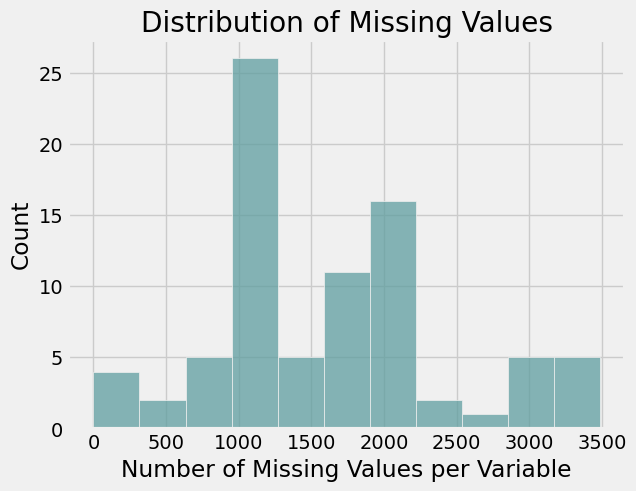

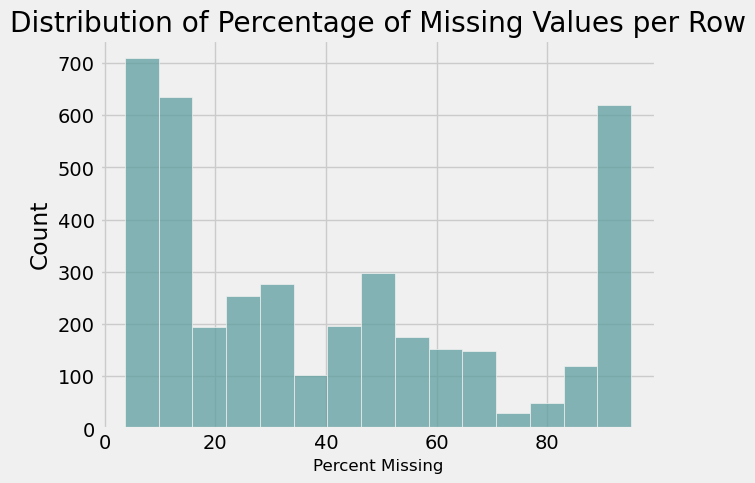

There are some rows that are missing almost all data...Maybe we should throw those out and see how many missing values we are left with.

For rows with over 80% of the data missing, these are the features they have the most data for:
There are 764 rows with 80% missingness.


id                                        0.000000
Basic_Demos-Enroll_Season                 0.000000
Basic_Demos-Age                           0.000000
Basic_Demos-Sex                           0.000000
PreInt_EduHx-Season                       0.481675
FGC-Season                                0.626963
Physical-Season                           0.641361
PreInt_EduHx-computerinternet_hoursday    0.672775
CGAS-Season                               0.772251
PAQ_C-PAQ_C_Total                         0.842932
PAQ_C-Season                              0.842932
Physical-Weight                           0.909686
Physical-Height                           0.920157
Physical-BMI                              0.920157
PAQ_A-Season                              0.926702
PAQ_A-PAQ_A_Total                         0.926702
Physical-HeartRate                        0.928010
Physical-Systolic_BP                      0.929319
Physical-Diastolic_BP                     0.929319
SDS-Season                     

In [157]:
print("\nMissing Values in Train Data:")
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0].sort_values())
sns.histplot(missing_values, color=color)
plt.title('Distribution of Missing Values')
plt.xlabel('Number of Missing Values per Variable')
plt.show()

percent_missing_per_row = train_data.isnull().mean(axis=1) * 100
sns.histplot(percent_missing_per_row, color='#5F9EA0')
plt.xlabel('Percent Missing', fontsize=12)
plt.title('Distribution of Percentage of Missing Values per Row')
plt.show()
print('There are some rows that are missing almost all data...Maybe we should throw those out and see how many missing values we are left with.')

print('\nFor rows with over 80% of the data missing, these are the features they have the most data for:')
high_missingness_idx = percent_missing_per_row[percent_missing_per_row > 80].index.values
print(f'There are {len(high_missingness_idx)} rows with 80% missingness.')
train_data.loc[high_missingness_idx].isna().mean().sort_values().head(20)

## Target Variable

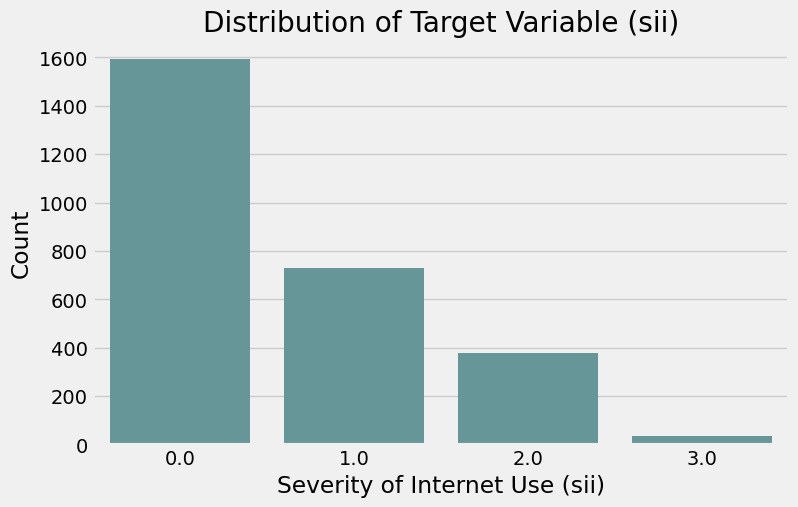

We have a very small proportion of 3's


sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [158]:
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='sii', color=color)
plt.xlabel('Severity of Internet Use (sii)')
plt.ylabel('Count')
plt.title('Distribution of Target Variable (sii)')
plt.show()

print('We have a very small proportion of 3\'s')
train_data['sii'].value_counts()

In [159]:
perc_NA = train_data['sii'].isna().mean()
print(f'{perc_NA*100:.2f}% of the target variable is missing')

30.91% of the target variable is missing


In [160]:
perc_NA = train_data['PCIAT-PCIAT_Total'].isna().mean()
print(f'{perc_NA*100:.2f}% of the "PCIAT-PCIAT_Total" is missing')

print('PCIAT-PCIAT_Total is nearly perfectly correlated with SII because SII was created from PCIAT-PCIAT_Total.')
print('These are the cutoffs that were used to create SII:')
train_data.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])

30.91% of the "PCIAT-PCIAT_Total" is missing
PCIAT-PCIAT_Total is nearly perfectly correlated with SII because SII was created from PCIAT-PCIAT_Total.
These are the cutoffs that were used to create SII:


,min,max
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [161]:
print('These are the variables that are most correlated with the target variable:')
numeric_df = train_data.select_dtypes(include=[np.number])
display(numeric_df.corr()['sii'].sort_values(ascending=False).head(30))
print('All of the most correlated variables are questions from the PCIAT, which makes sense since SII was created from PCIAT.')
print('After that, height, age, and internet usage are most correlated.')

These are the variables that are most correlated with the target variable:


sii                                       1.000000
PCIAT-PCIAT_Total                         0.899681
PCIAT-PCIAT_15                            0.751399
PCIAT-PCIAT_18                            0.731112
PCIAT-PCIAT_17                            0.729867
PCIAT-PCIAT_05                            0.722722
PCIAT-PCIAT_13                            0.705679
PCIAT-PCIAT_20                            0.703013
PCIAT-PCIAT_16                            0.698566
PCIAT-PCIAT_08                            0.695458
PCIAT-PCIAT_03                            0.694736
PCIAT-PCIAT_02                            0.694597
PCIAT-PCIAT_10                            0.689972
PCIAT-PCIAT_19                            0.683293
PCIAT-PCIAT_14                            0.675953
PCIAT-PCIAT_09                            0.660485
PCIAT-PCIAT_06                            0.645596
PCIAT-PCIAT_01                            0.617883
PCIAT-PCIAT_11                            0.609964
PCIAT-PCIAT_04                 

All of the most correlated variables are questions from the PCIAT, which makes sense since SII was created from PCIAT.
After that, height, age, and internet usage are most correlated.


In [162]:
# What are the characteristics of people who are missing vs. aren't missing SII?

# Univariate Predictor Exploration
Below we plot all the responses for each of the instruments used to assess participants. There are a lot of measures within and between instruments that are redundant, so we should definitely look into which features to use. Also, when one measurement is missing, a comparable measure from a different instrument may be present. For example, there are separate physical activity questionnaires for adolescents nad children, leading to high missingness.

In [163]:
print('These are all the instruments.')
data_dictionary['Instrument'].unique()

These are all the instruments.


array(['Identifier', 'Demographics', "Children's Global Assessment Scale",
       'Physical Measures', 'FitnessGram Vitals and Treadmill',
       'FitnessGram Child', 'Bio-electric Impedance Analysis',
       'Physical Activity Questionnaire (Adolescents)',
       'Physical Activity Questionnaire (Children)',
       'Parent-Child Internet Addiction Test', 'Sleep Disturbance Scale',
       'Internet Use'], dtype=object)

In [164]:
train_data['PCIAT-PCIAT_01'].dtype

dtype('float64')

In [165]:
# plotting function!
def plot_columns(cols, data_dictionary, train_data, suptitle, num_cols=3):
    """
    This function plots barplots or histograms for the given columns based on their types.
    All the plots are places in one figure.

    Parameters:
    - cols: List of column names to plot.
    - data_dictionary: DataFrame containing descriptions and types of the columns.
    - train_data: DataFrame with the data to be visualized.
    - num_cols: Number of columns per row in the plot (default is 2).
    """
    
    # Determine the number of rows required based on the number of columns to plot
    num_rows = math.ceil(len(cols) / num_cols)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))
    axes = axes.flatten()

    # Loop over columns and plot the corresponding chart
    for i, col in enumerate(cols):
        ax = axes[i]
        description = data_dictionary.loc[data_dictionary['Field'] == col, 'Description'].values
        title_text = f'{col}: {description[0] if len(description) > 0 else "No description available"}'
        
        # Wrap title text to prevent long titles from overflowing
        wrapped_title = "\n".join(textwrap.wrap(title_text, width=40))
        col_type = data_dictionary.loc[data_dictionary['Field'] == col, 'Type'].values[0]
        
        # Plot based on the column type
        if col_type == 'str' or col_type == 'categorical int':
            sns.barplot(
                x=train_data[col].value_counts().index,
                y=train_data[col].value_counts(),
                color='#5F9EA0',
                ax=ax
            )
        elif col_type == 'int' or col_type == 'float':
            sns.histplot(
                x=train_data[col],
                color='#5F9EA0',
                ax=ax
            )    
        ax.set_title(wrapped_title, fontsize=12)
        ax.set_xlabel('Response', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.tick_params(axis='x', rotation=30)

    # Remove unused subplots if there are any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a main title for the entire figure
    fig.suptitle(suptitle, fontsize=16, weight='bold', y=1)

    # Adjust layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.6)

    # Show the plot
    plt.show()

## Demographics
Use Basic_Demos-Age and Basic_Demos-Sex as controls

In [166]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Demographics', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'Demographics', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Demographics', ['Field','Value Labels']])

print('\nThis is the missingness for each demo question:')
train_data[cols].isna().mean()

,Field,Description
1,Basic_Demos-Enroll_Season,Season of enrollment
2,Basic_Demos-Age,Age of participant
3,Basic_Demos-Sex,Sex of participant



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
1,Basic_Demos-Enroll_Season,NaN
2,Basic_Demos-Age,NaN
3,Basic_Demos-Sex,"0=Male, 1=Female"



This is the missingness for each demo question:


Basic_Demos-Enroll_Season    0.0
Basic_Demos-Age              0.0
Basic_Demos-Sex              0.0
dtype: float64

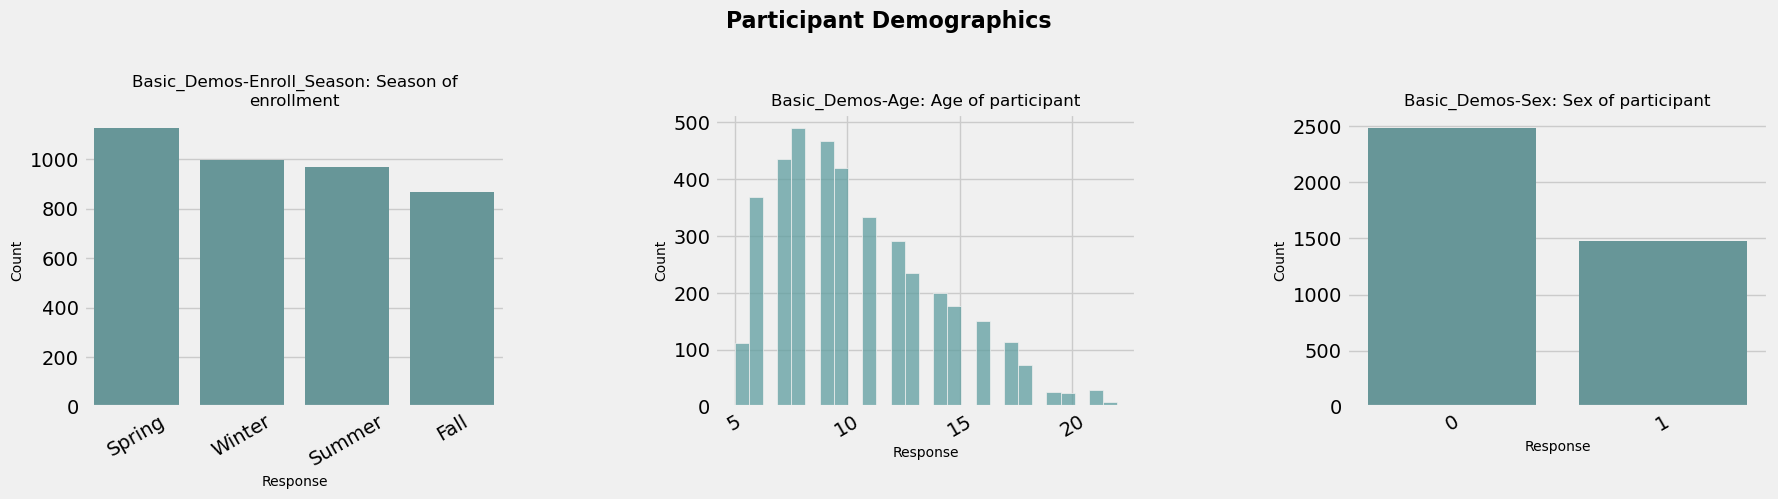

In [167]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'Participant Demographics', num_cols=3)

## Children's Global Assessment Scale

In [168]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == "Children's Global Assessment Scale", ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == "Children's Global Assessment Scale", 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == "Children's Global Assessment Scale", ['Field','Value Labels']])

print('\nThis is the missingness for each CGAS question:')
train_data[cols].isna().mean()

,Field,Description
4,CGAS-Season,Season of participation
5,CGAS-CGAS_Score,Children's Global Assessment Scale Score



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
4,CGAS-Season,NaN
5,CGAS-CGAS_Score,NaN



This is the missingness for each CGAS question:


CGAS-Season        0.354798
CGAS-CGAS_Score    0.388636
dtype: float64

In [169]:
display(train_data['CGAS-CGAS_Score'].sort_values(ascending=False))
print('The maximum value is 99, so it looks like we should fix one value. Should check for test data as well')
# probably misentered, so changing to 99
train_data.loc[2065, 'CGAS-CGAS_Score'] = 99

2065    999.0
2926     95.0
3713     95.0
667      95.0
1007     95.0
        ...  
3951      NaN
3953      NaN
3954      NaN
3956      NaN
3959      NaN
Name: CGAS-CGAS_Score, Length: 3960, dtype: float64

The maximum value is 99, so it looks like we should fix one value. Should check for test data as well


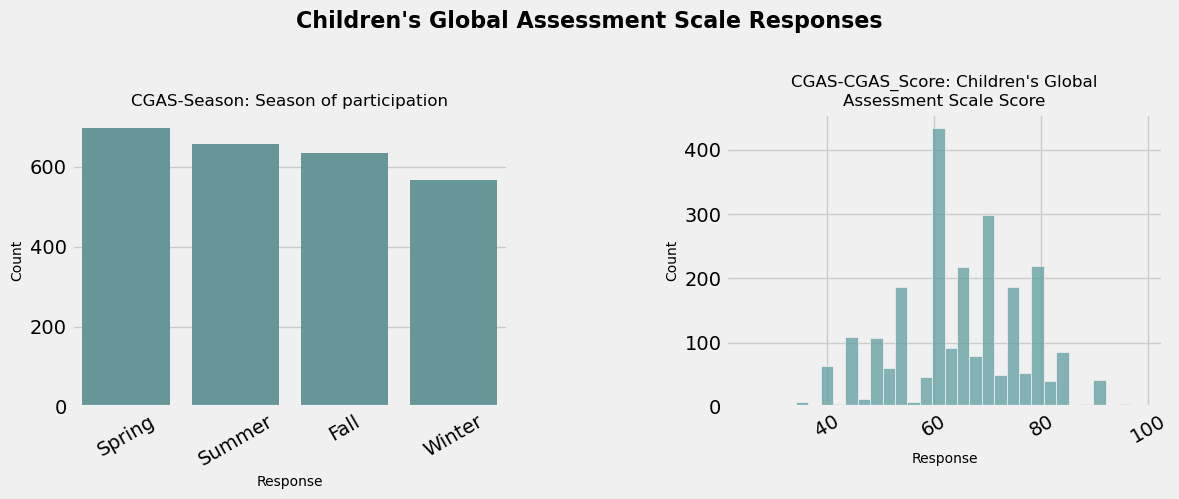

In [170]:
plot_columns(cols, data_dictionary, train_data, suptitle = "Children's Global Assessment Scale Responses", num_cols=2)

## Physical Measures
Potentially use Physical-BMI, Physical-Height, Physical-Weight, Physical-Waist_Circumference, Physical-Diastolic_BP, Physical-HeartRate, Physical-Systolic_BP

Weight, height, BMI, and waist cirumference are all highly related and potentially redundant.

In [171]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Measures', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Measures', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Measures', ['Field','Value Labels']])

print('\nThis is the missingness for each Physical question:')
train_data[cols].isna().mean()

,Field,Description
6,Physical-Season,Season of participation
7,Physical-BMI,Body Mass Index (kg/m^2)
8,Physical-Height,Height (in)
9,Physical-Weight,Weight (lbs)
10,Physical-Waist_Circumference,Waist circumference (in)
11,Physical-Diastolic_BP,Diastolic BP (mmHg)
12,Physical-HeartRate,Heart rate (beats/min)
13,Physical-Systolic_BP,Systolic BP (mmHg)



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
6,Physical-Season,NaN
7,Physical-BMI,NaN
8,Physical-Height,NaN
9,Physical-Weight,NaN
10,Physical-Waist_Circumference,NaN
11,Physical-Diastolic_BP,NaN
12,Physical-HeartRate,NaN
13,Physical-Systolic_BP,NaN



This is the missingness for each Physical question:


Physical-Season                 0.164141
Physical-BMI                    0.236869
Physical-Height                 0.235606
Physical-Weight                 0.223232
Physical-Waist_Circumference    0.773232
Physical-Diastolic_BP           0.254040
Physical-HeartRate              0.250758
Physical-Systolic_BP            0.254040
dtype: float64

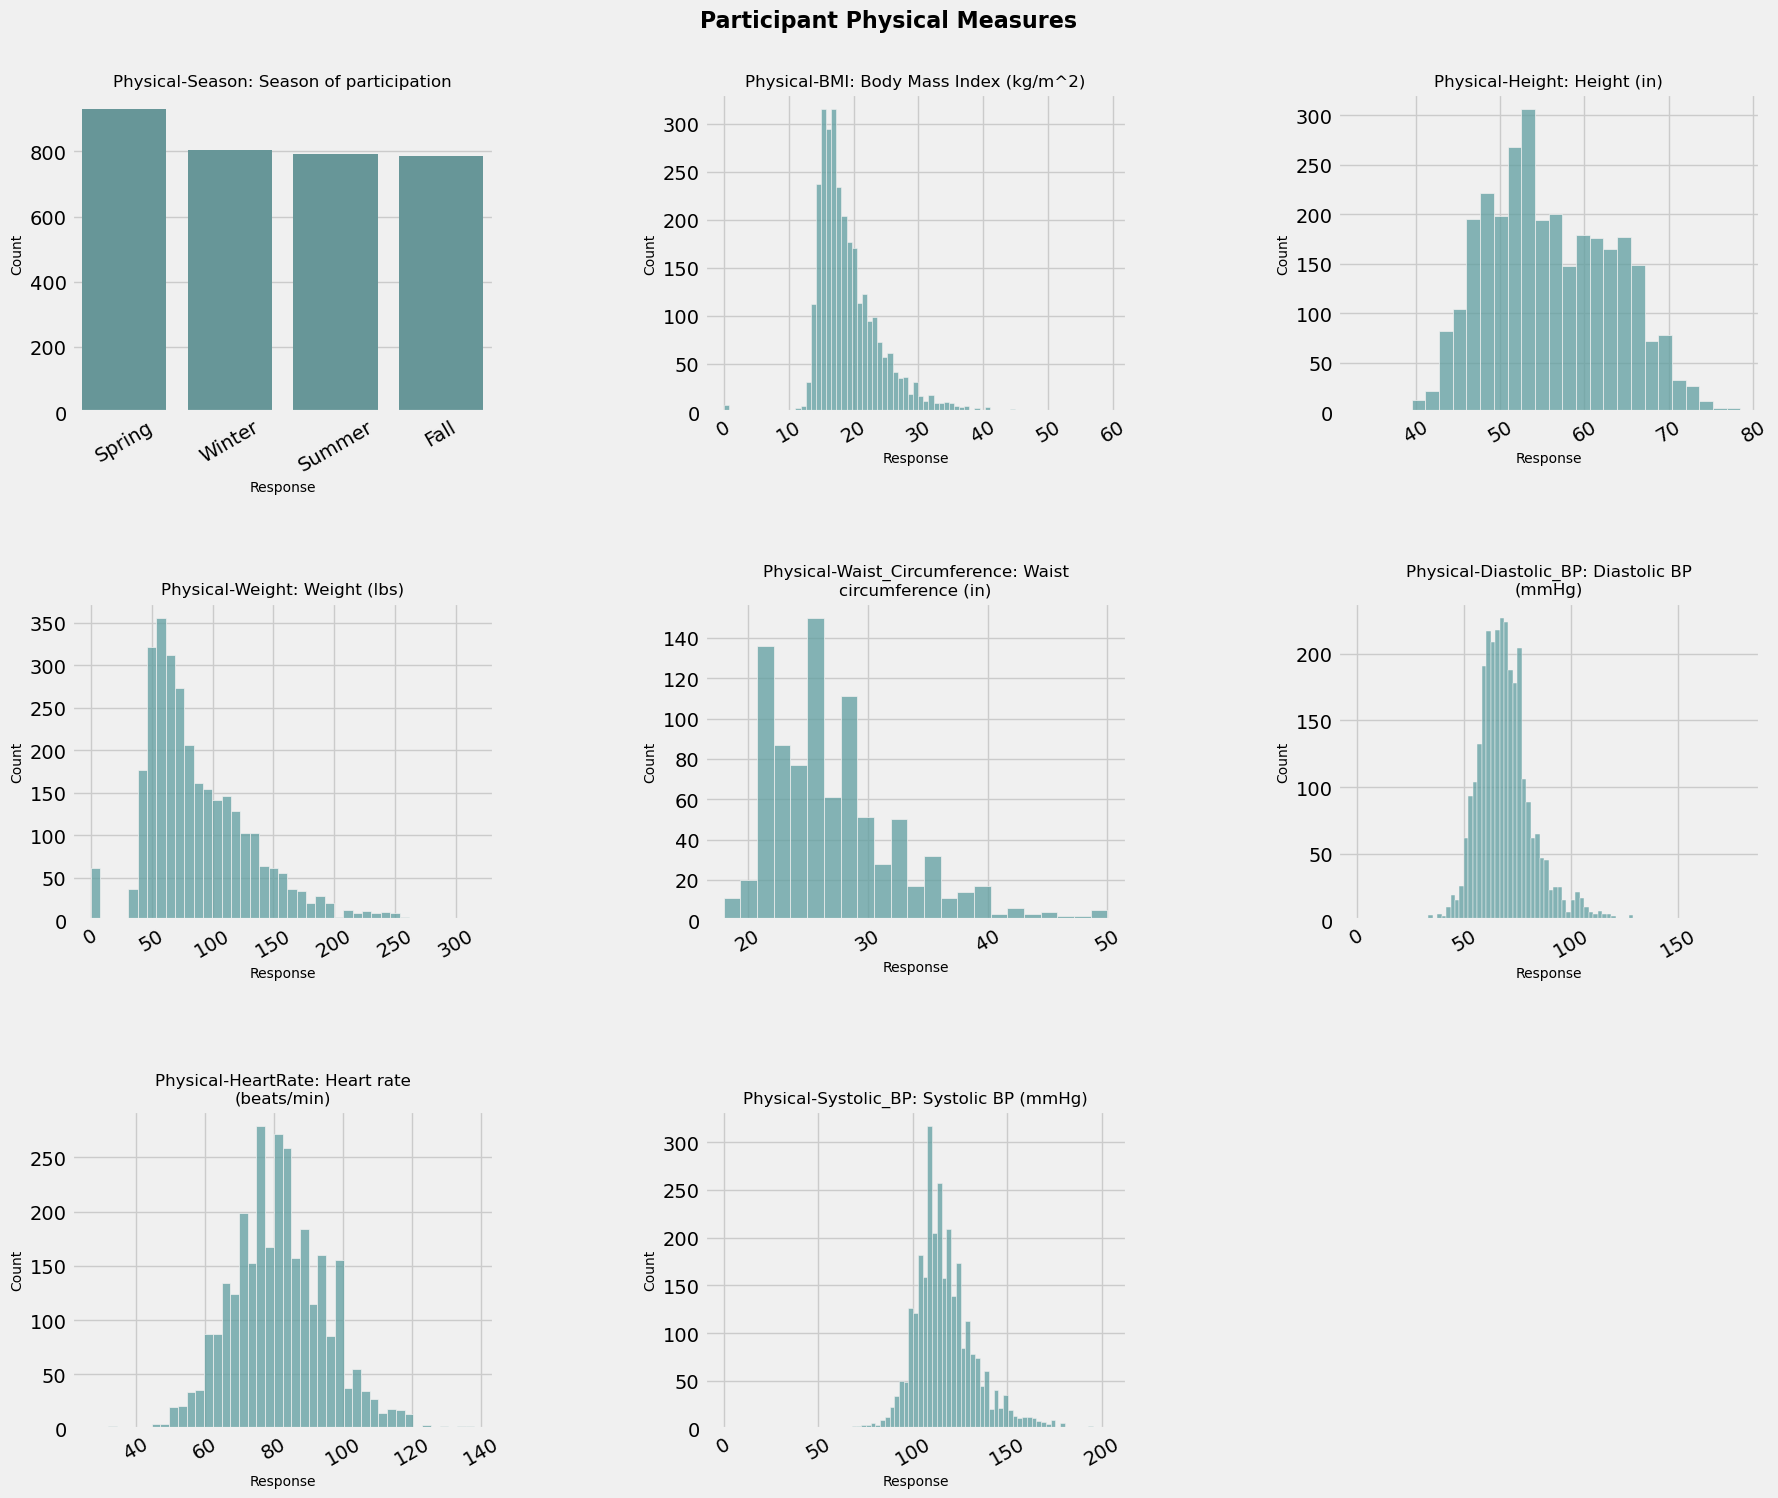

In [172]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'Participant Physical Measures', num_cols=3)

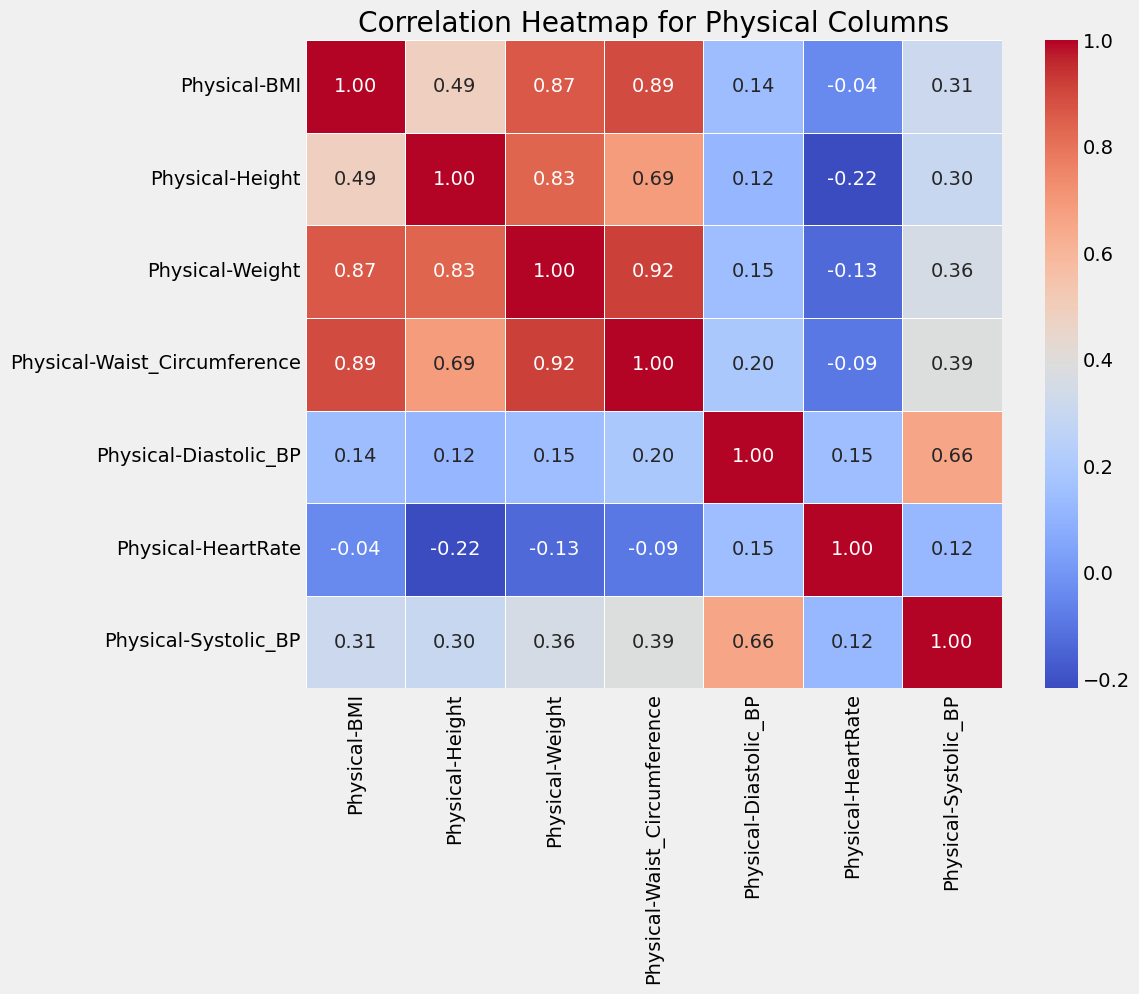

Some of the physical measures are redundant, so it may be best to use PCA to reduce the number of features.


In [173]:
physical_cols = numeric_df.filter(regex=r'^Physical', axis=1).columns
physical_df = numeric_df[physical_cols]
cormat = physical_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cormat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Physical Columns")
plt.show()
print('Some of the physical measures are redundant, so it may be best to use PCA to reduce the number of features.')

## FitnessGram Vitals and Treadmill
Combine time in minutes and seconds, and remove other columns

In [174]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'FitnessGram Vitals and Treadmill', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'FitnessGram Vitals and Treadmill', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'FitnessGram Vitals and Treadmill', ['Field','Value Labels']])

print('\nThis is the missingness for each FitnessGram question:')
train_data[cols].isna().mean()

,Field,Description
14,Fitness_Endurance-Season,Season of participation
15,Fitness_Endurance-Max_Stage,Maximum stage reached
16,Fitness_Endurance-Time_Mins,Exact time completed: Minutes
17,Fitness_Endurance-Time_Sec,Exact time completed: Seconds



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
14,Fitness_Endurance-Season,NaN
15,Fitness_Endurance-Max_Stage,NaN
16,Fitness_Endurance-Time_Mins,NaN
17,Fitness_Endurance-Time_Sec,NaN



This is the missingness for each FitnessGram question:


Fitness_Endurance-Season       0.669697
Fitness_Endurance-Max_Stage    0.812374
Fitness_Endurance-Time_Mins    0.813131
Fitness_Endurance-Time_Sec     0.813131
dtype: float64

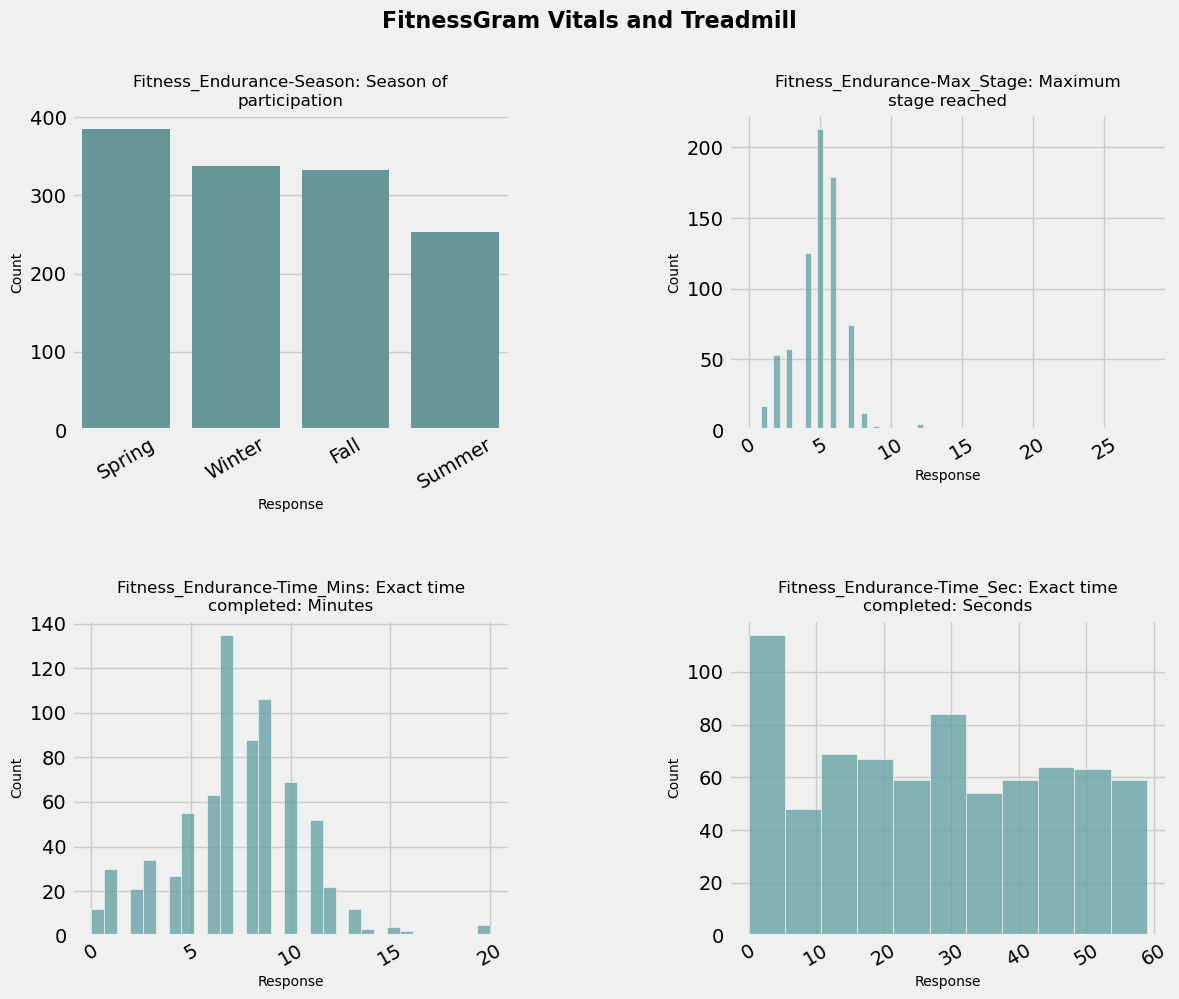

In [175]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'FitnessGram Vitals and Treadmill', num_cols=2)

In [176]:
train_data[cols]

,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,Fall,5.0,7.0,33.0
3,Summer,6.0,9.0,37.0
4,NaN,NaN,NaN,NaN
...,...,...,...,...
3955,NaN,NaN,NaN,NaN
3956,NaN,NaN,NaN,NaN
3957,NaN,NaN,NaN,NaN
3958,NaN,NaN,NaN,NaN


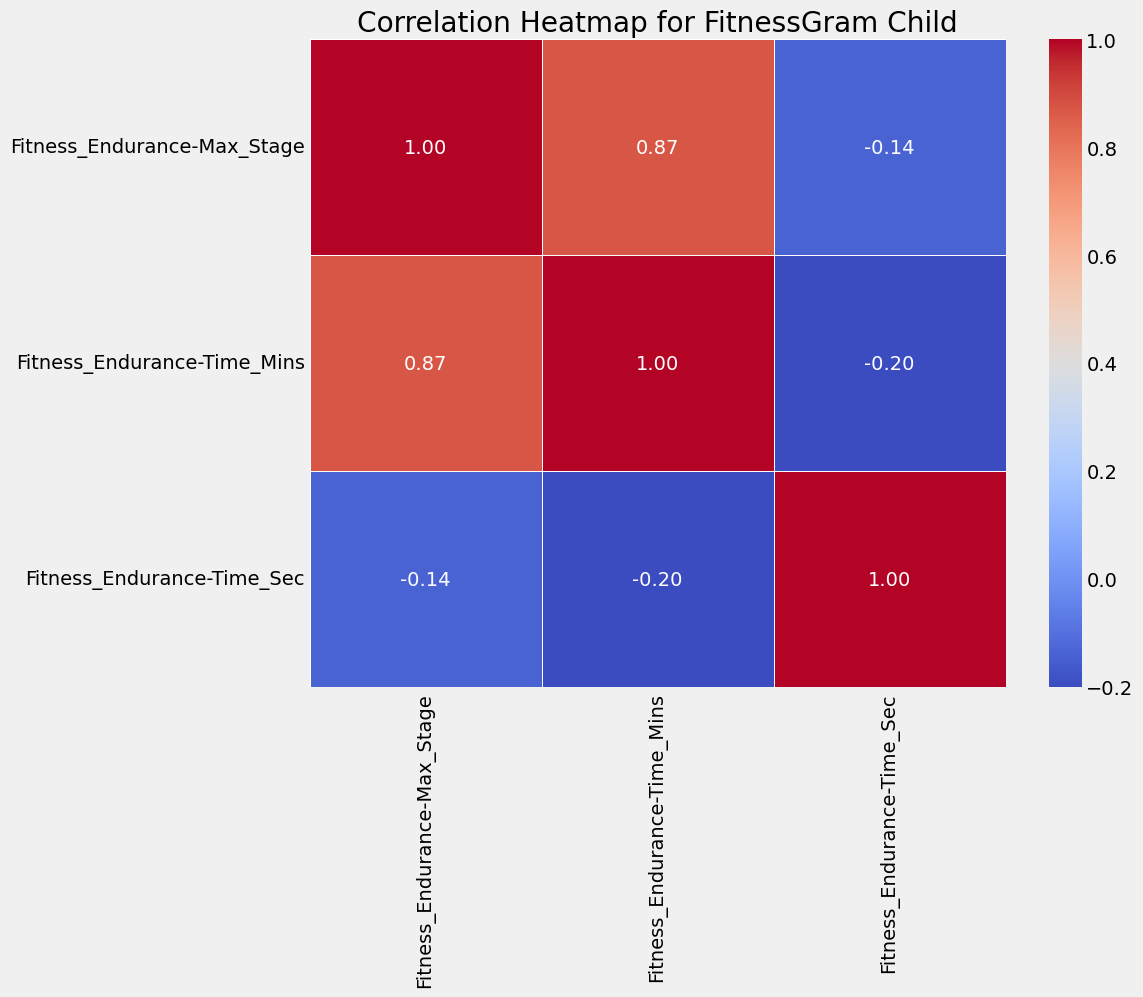

Some of the physical measures are redundant, so it may be best to use PCA to reduce the number of features.


In [177]:
physical_cols = numeric_df.filter(regex=r'^Fitness_Endurance', axis=1).columns
physical_df = numeric_df[physical_cols]
cormat = physical_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cormat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for FitnessGram Child")
plt.show()
print('Some of the physical measures are redundant, so it may be best to use PCA to reduce the number of features.')

## FitnessGram Child
Some of the FitnessGram features are redundant because the measures are repeated on domininat and non-dominant sides, but otherwise they aren't very correlated.

In [178]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'FitnessGram Child', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'FitnessGram Child', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'FitnessGram Child', ['Field','Value Labels']])

print('\nThis is the missingness for each FitnessGram question:')
train_data[cols].isna().mean()

,Field,Description
18,FGC-Season,Season of participation
19,FGC-FGC_CU,Curl up total
20,FGC-FGC_CU_Zone,Curl up fitness zone
21,FGC-FGC_GSND,Grip Strength total (non-dominant)
22,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant)
23,FGC-FGC_GSD,Grip Strength total (dominant)
24,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant)
25,FGC-FGC_PU,Push-up total
26,FGC-FGC_PU_Zone,Push-up fitness zone
27,FGC-FGC_SRL,Sit & Reach total (left side)



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
18,FGC-Season,NaN
19,FGC-FGC_CU,NaN
20,FGC-FGC_CU_Zone,"0=Needs Improvement, 1=Healthy Fitness Zone"
21,FGC-FGC_GSND,NaN
22,FGC-FGC_GSND_Zone,"1=Weak, 2=Normal, 3=Strong"
23,FGC-FGC_GSD,NaN
24,FGC-FGC_GSD_Zone,"1=Weak, 2=Normal, 3=Strong"
25,FGC-FGC_PU,NaN
26,FGC-FGC_PU_Zone,"0=Needs Improvement, 1=Healthy Fitness Zone"
27,FGC-FGC_SRL,NaN



This is the missingness for each FitnessGram question:


FGC-Season           0.155051
FGC-FGC_CU           0.413636
FGC-FGC_CU_Zone      0.423737
FGC-FGC_GSND         0.728788
FGC-FGC_GSND_Zone    0.731818
FGC-FGC_GSD          0.728788
FGC-FGC_GSD_Zone     0.731566
FGC-FGC_PU           0.416667
FGC-FGC_PU_Zone      0.426515
FGC-FGC_SRL          0.417929
FGC-FGC_SRL_Zone     0.427525
FGC-FGC_SRR          0.417424
FGC-FGC_SRR_Zone     0.427020
FGC-FGC_TL           0.413131
FGC-FGC_TL_Zone      0.422980
dtype: float64

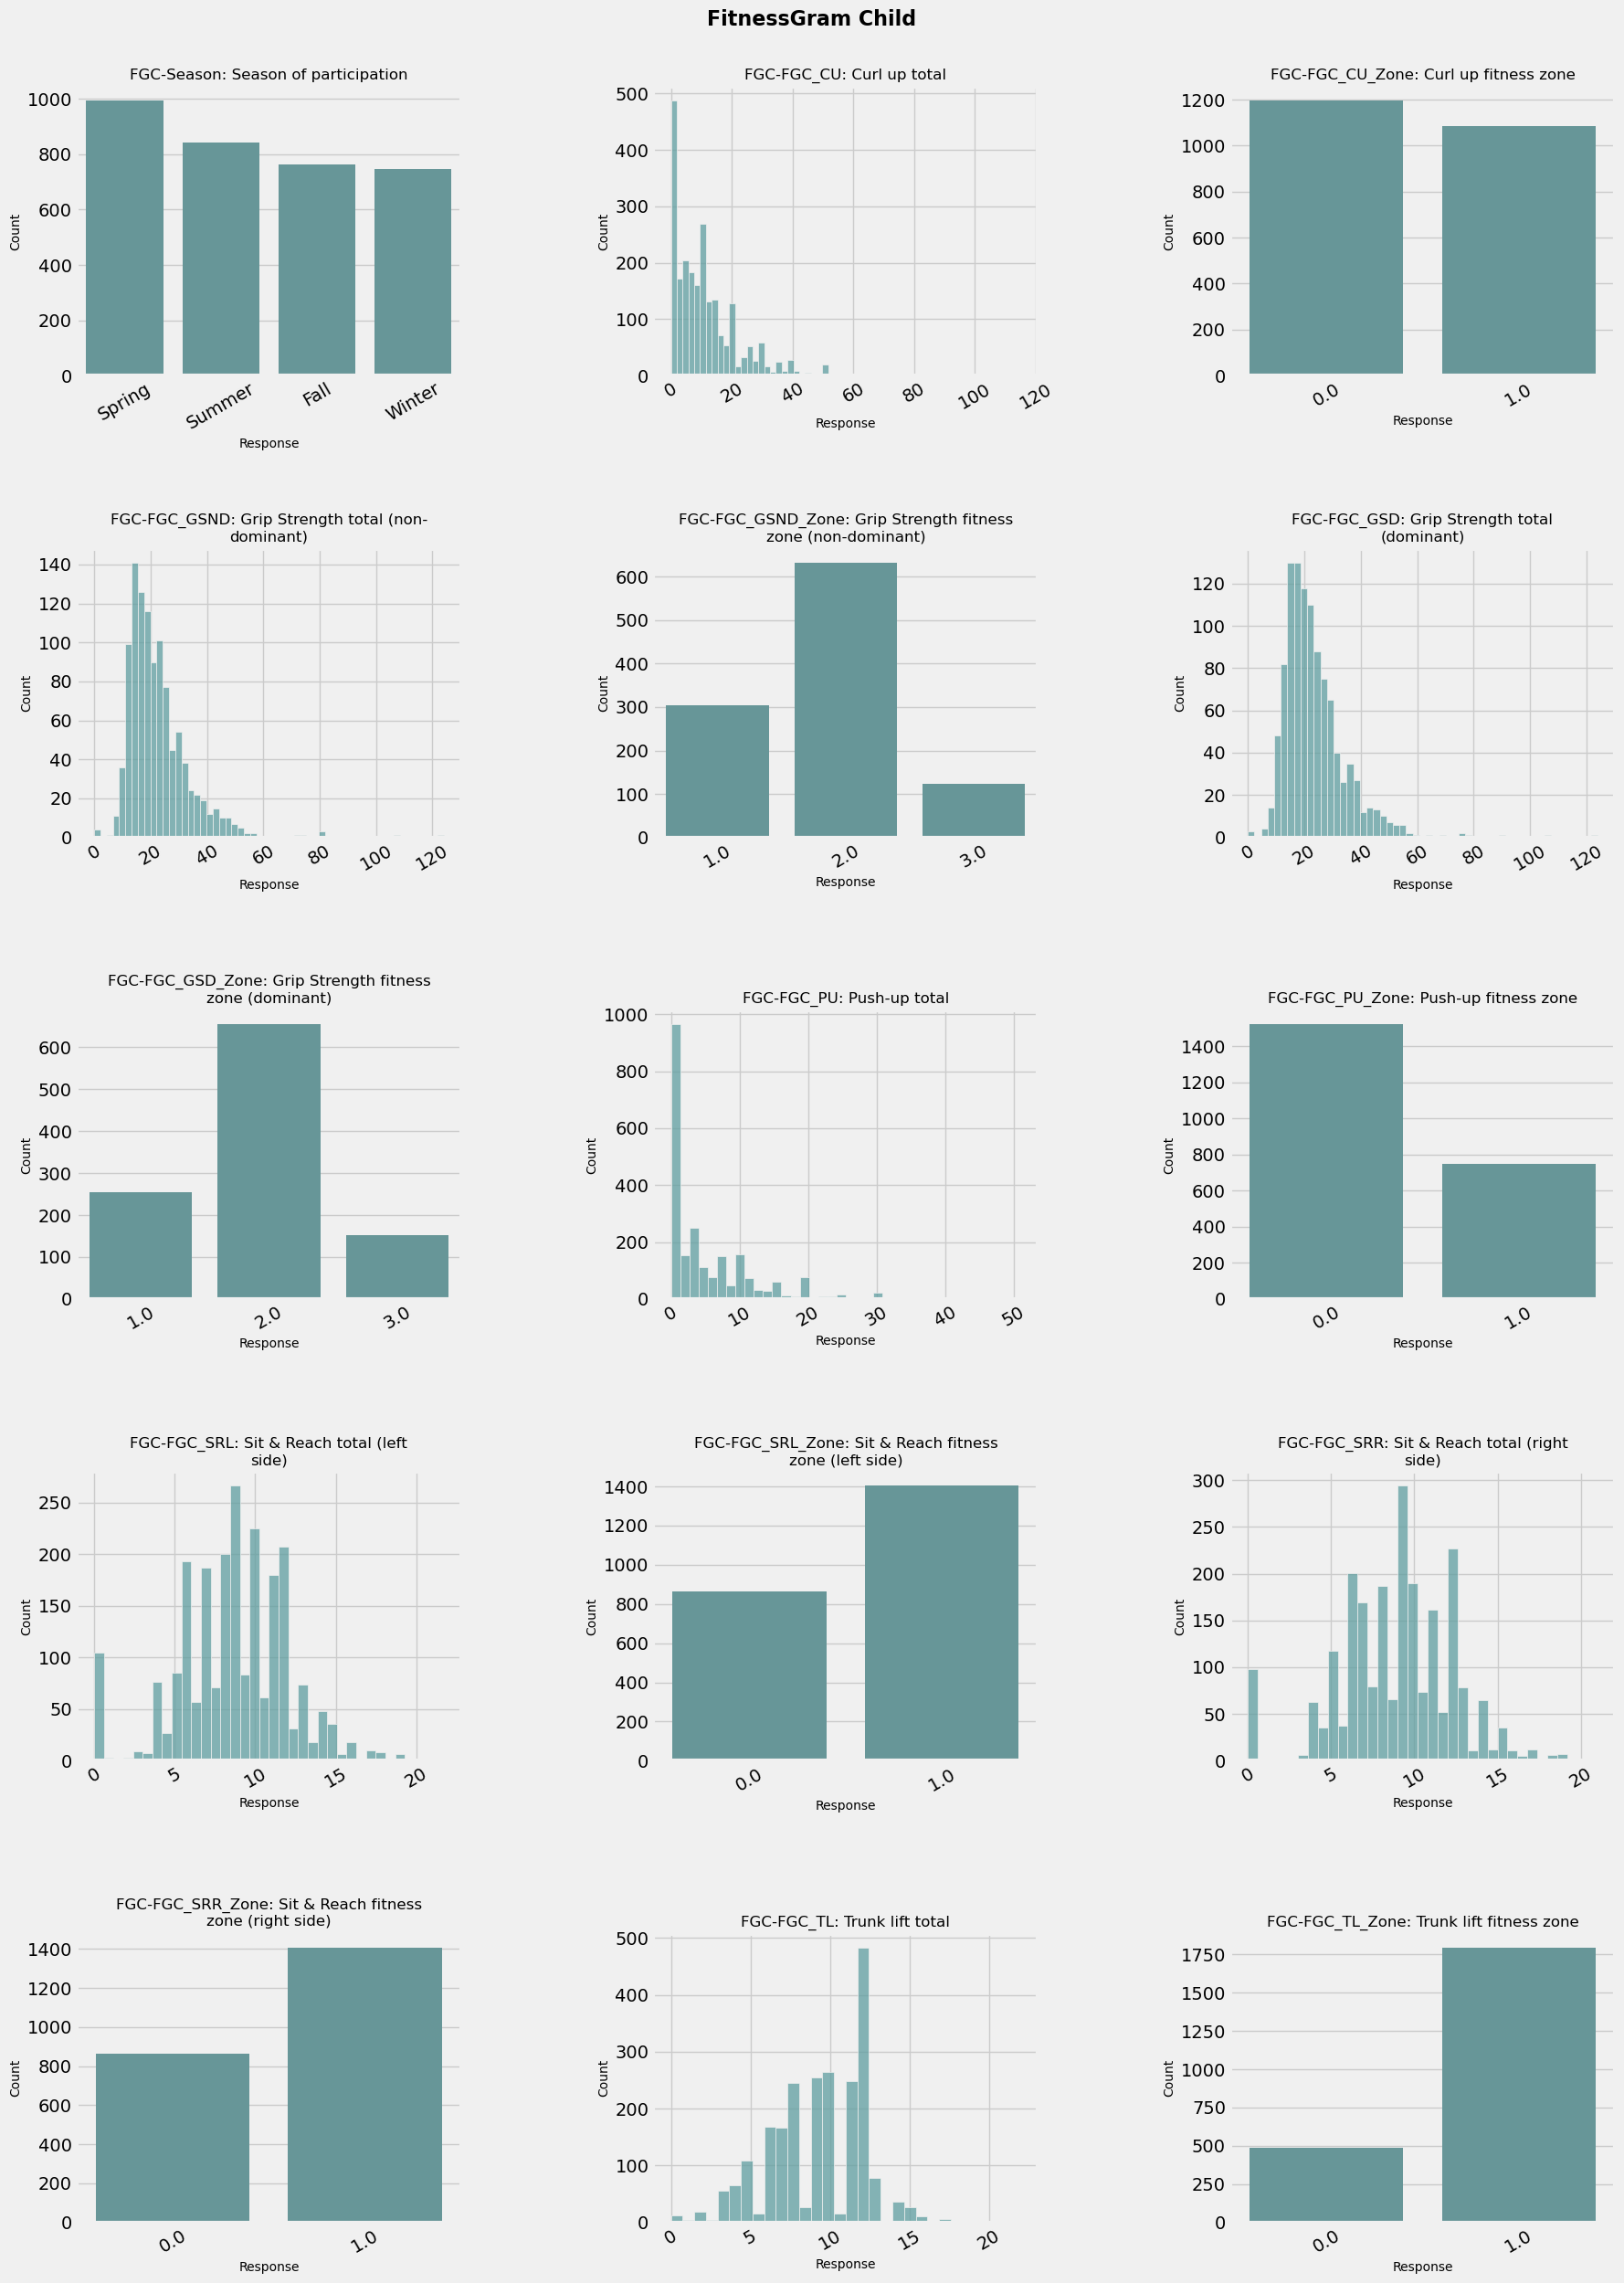

In [179]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'FitnessGram Child', num_cols=3)

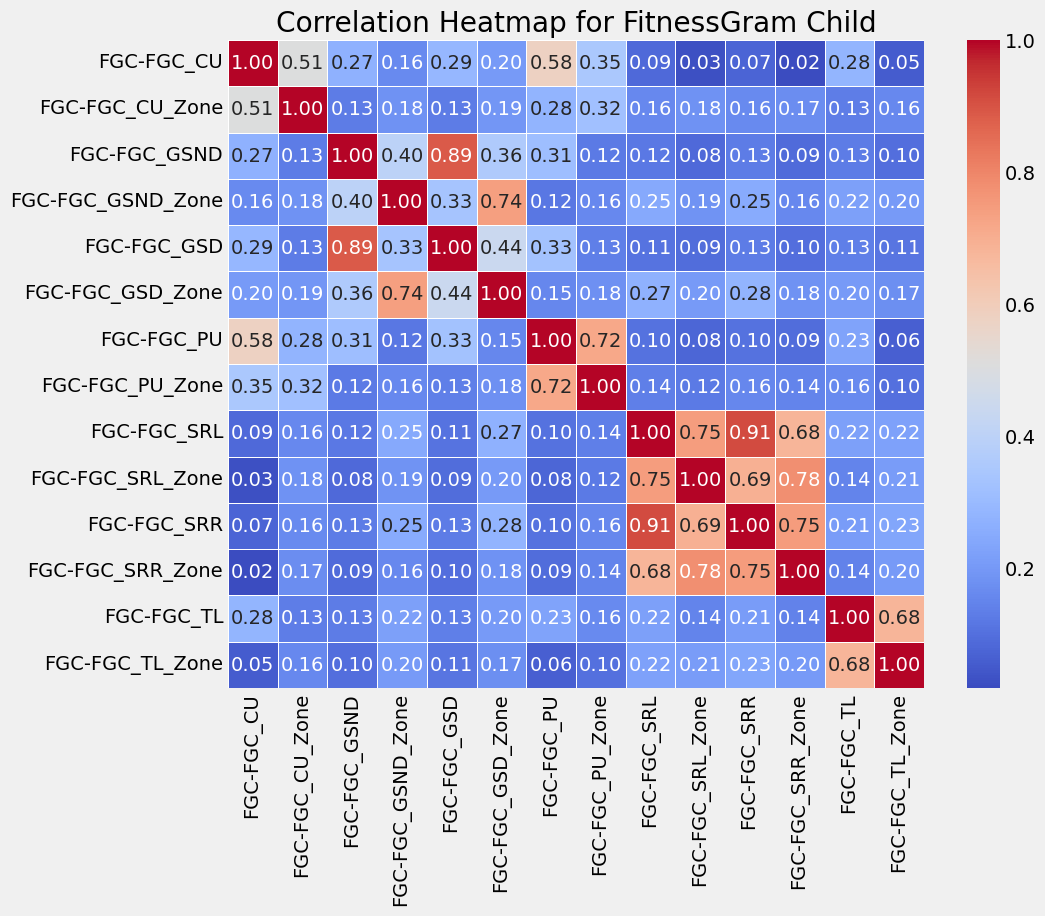

Some of the physical measures are redundant, so it may be best to use PCA to reduce the number of features.


In [180]:
FG_cols = numeric_df.filter(regex=r'^FGC-FGC', axis=1).columns
FG_df = numeric_df[FG_cols]
cormat = FG_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cormat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for FitnessGram Child")
plt.show()
print('Some of the physical measures are redundant, so it may be best to use PCA to reduce the number of features.')

## Bio-electric Impedance Analysis
BIA-BIA_Activity_Level_num may be redundant with other activity measures

From Chat: Bioelectric Impedance Analysis (BIA) is a non-invasive method used to assess body composition, specifically the amount of fat, muscle, and water in the body, by measuring the resistance and reactance of body tissues to a small, harmless electrical current.

Removed strange outliers. Should automate this for test data.

In [181]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Bio-electric Impedance Analysis', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'Bio-electric Impedance Analysis', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Bio-electric Impedance Analysis', ['Field','Value Labels']])

print('\nThis is the missingness for each BIA question:')
train_data[cols].isna().mean()

,Field,Description
33,BIA-Season,Season of participation
34,BIA-BIA_Activity_Level_num,Activity Level
35,BIA-BIA_BMC,Bone Mineral Content
36,BIA-BIA_BMI,Body Mass Index
37,BIA-BIA_BMR,Basal Metabolic Rate
38,BIA-BIA_DEE,Daily Energy Expenditure
39,BIA-BIA_ECW,Extracellular Water
40,BIA-BIA_FFM,Fat Free Mass
41,BIA-BIA_FFMI,Fat Free Mass Index
42,BIA-BIA_FMI,Fat Mass Index



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
33,BIA-Season,NaN
34,BIA-BIA_Activity_Level_num,"1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,BIA-BIA_BMC,NaN
36,BIA-BIA_BMI,NaN
37,BIA-BIA_BMR,NaN
38,BIA-BIA_DEE,NaN
39,BIA-BIA_ECW,NaN
40,BIA-BIA_FFM,NaN
41,BIA-BIA_FFMI,NaN
42,BIA-BIA_FMI,NaN



This is the missingness for each BIA question:


BIA-Season                    0.458333
BIA-BIA_Activity_Level_num    0.497222
BIA-BIA_BMC                   0.497222
BIA-BIA_BMI                   0.497222
BIA-BIA_BMR                   0.497222
BIA-BIA_DEE                   0.497222
BIA-BIA_ECW                   0.497222
BIA-BIA_FFM                   0.497222
BIA-BIA_FFMI                  0.497222
BIA-BIA_FMI                   0.497222
BIA-BIA_Fat                   0.497222
BIA-BIA_Frame_num             0.497222
BIA-BIA_ICW                   0.497222
BIA-BIA_LDM                   0.497222
BIA-BIA_LST                   0.497222
BIA-BIA_SMM                   0.497222
BIA-BIA_TBW                   0.497222
dtype: float64

In [182]:
# I think there are some outliers that shouldn't be there
cols2 = data_dictionary.loc[(data_dictionary['Instrument'] == 'Bio-electric Impedance Analysis') & (data_dictionary['Type'] == 'float'), 'Field']
print('There are some outliers that shouldn\'t be there.')
train_data[cols2].describe()

# should automatically remove the crazy outliers
# remove 3511 and 3205's BIA values because they seem wrong. They have normal heights and weights but extreme values for BIA measures
train_data.loc[[3205, 3511], cols2] = np.nan

There are some outliers that shouldn't be there.


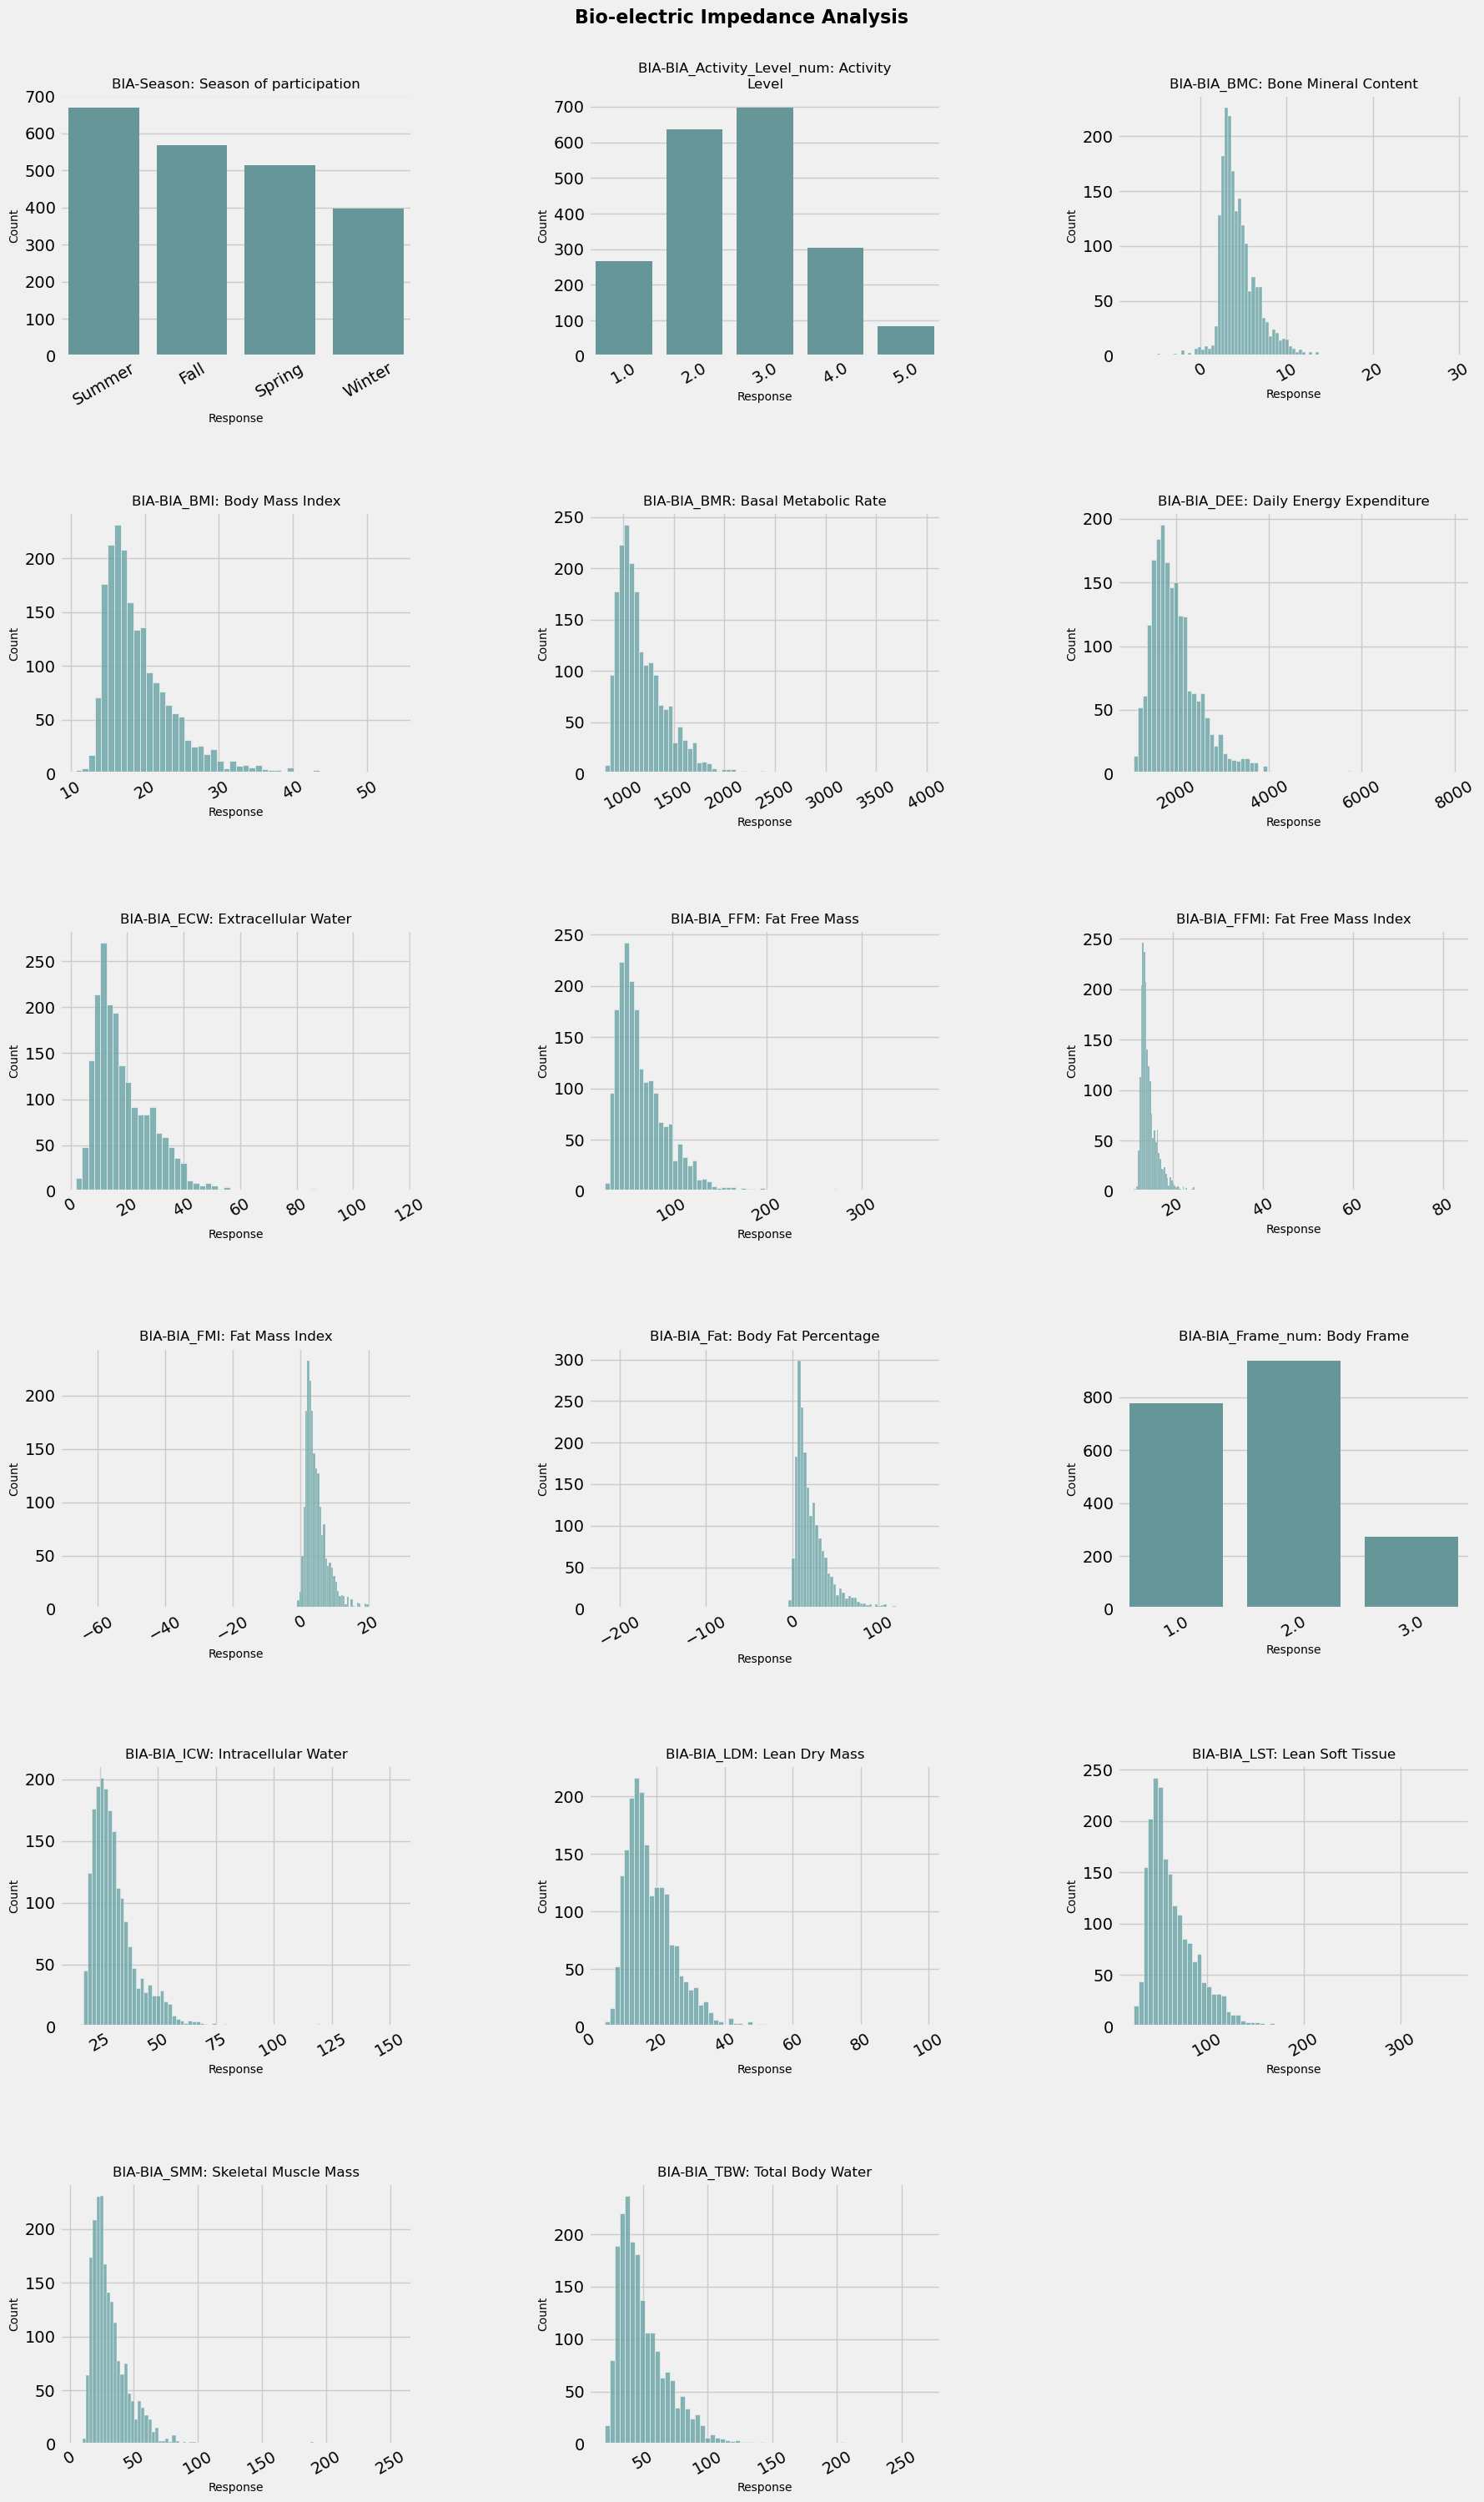

In [183]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'Bio-electric Impedance Analysis', num_cols=3)

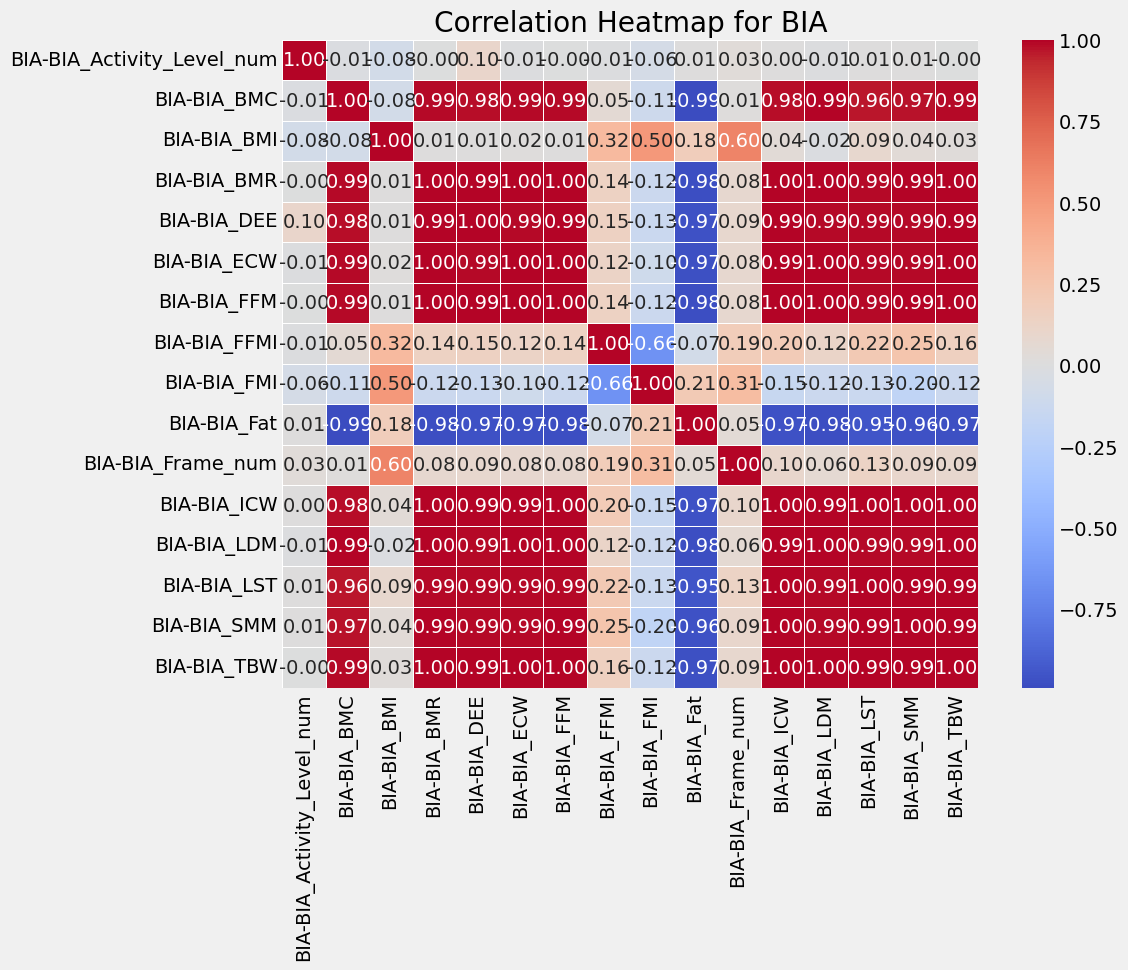

In [184]:
BIA_cols = numeric_df.filter(regex=r'^BIA-BIA', axis=1).columns
BIA_df = numeric_df[BIA_cols]
cormat = BIA_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cormat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for BIA")
plt.show()

## Physical Activity Questionnaire (Adolescents)

In [185]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Activity Questionnaire (Adolescents)', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Activity Questionnaire (Adolescents)', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Activity Questionnaire (Adolescents)', ['Field','Value Labels']])

print('\nThis is the missingness for each PAQ-A question:')
train_data[cols].isna().mean()

,Field,Description
50,PAQ_A-Season,Season of participation
51,PAQ_A-PAQ_A_Total,Activity Summary Score (Adolescents)



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
50,PAQ_A-Season,NaN
51,PAQ_A-PAQ_A_Total,NaN



This is the missingness for each PAQ-A question:


PAQ_A-Season         0.880051
PAQ_A-PAQ_A_Total    0.880051
dtype: float64

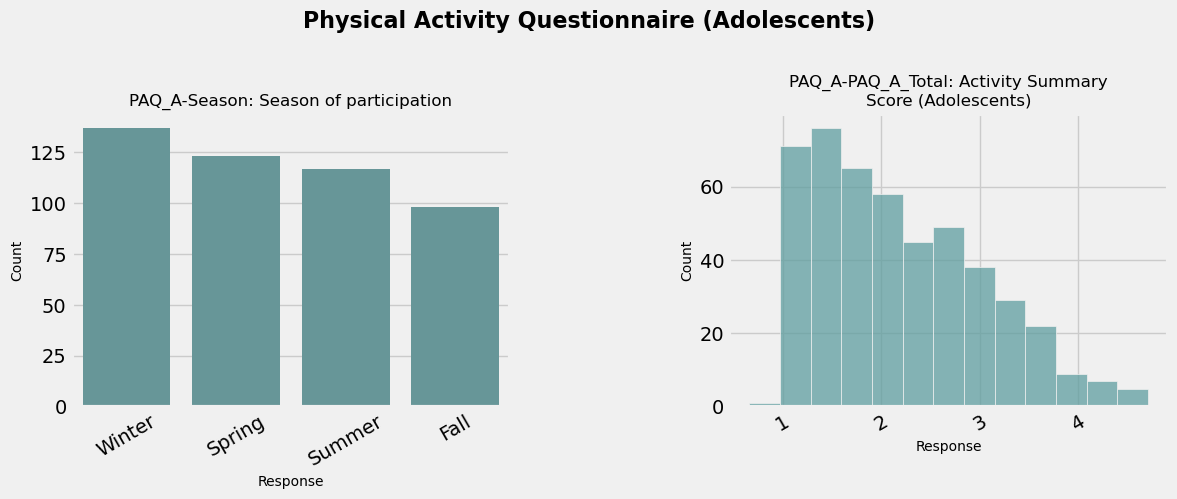

In [186]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'Physical Activity Questionnaire (Adolescents)', num_cols=2)

## Physical Activity Questionnaire (Children)

In [187]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Activity Questionnaire (Children)', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Activity Questionnaire (Children)', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Physical Activity Questionnaire (Children)', ['Field','Value Labels']])

print('\nThis is the missingness for each PAQ-C question:')
train_data[cols].isna().mean()

,Field,Description
52,PAQ_C-Season,Season of participation
53,PAQ_C-PAQ_C_Total,Activity Summary Score (Children)



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
52,PAQ_C-Season,NaN
53,PAQ_C-PAQ_C_Total,NaN



This is the missingness for each PAQ-C question:


PAQ_C-Season         0.565404
PAQ_C-PAQ_C_Total    0.565404
dtype: float64

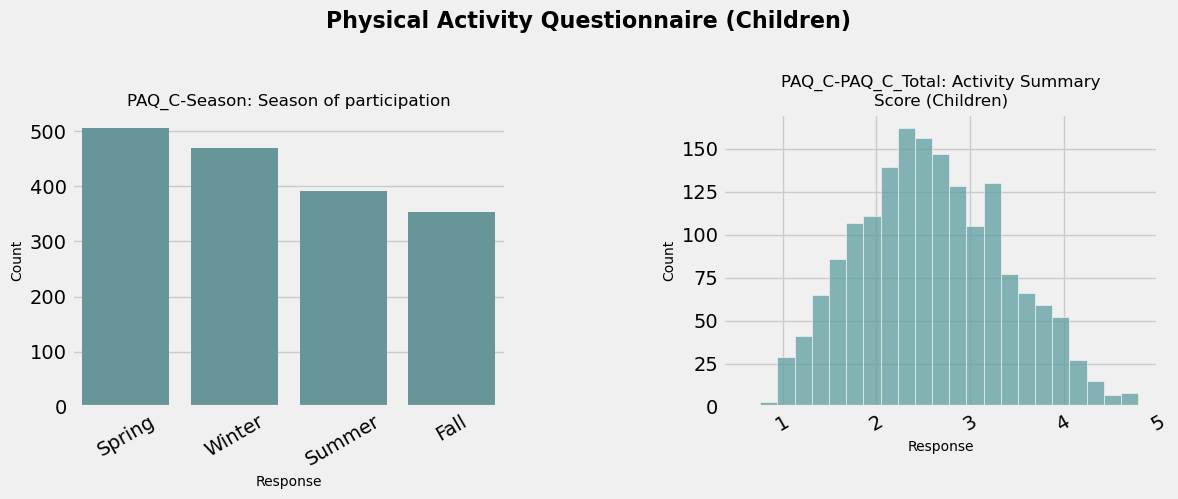

In [188]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'Physical Activity Questionnaire (Children)', num_cols=2)

## Parent-Child Internet Addiction Test
Target is derived from this variable.

In [189]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Parent-Child Internet Addiction Test', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'Parent-Child Internet Addiction Test', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Parent-Child Internet Addiction Test', ['Field','Value Labels']])

print('The value labels are the same for every question. Here are the labels so you can see them better.')
print(data_dictionary.loc[data_dictionary['Field'] == 'PCIAT-PCIAT_01', 'Value Labels'].values)

print('\nThis is the missingness for each PCIAT question:')
train_data[cols].isna().mean()

,Field,Description
54,PCIAT-Season,Season of participation
55,PCIAT-PCIAT_01,How often does your child disobey time limits ...
56,PCIAT-PCIAT_02,How often does your child neglect household ch...
57,PCIAT-PCIAT_03,How often does your child prefer to spend time...
58,PCIAT-PCIAT_04,How often does your child form new relationshi...
59,PCIAT-PCIAT_05,How often do you complain about the amount of ...
60,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...
61,PCIAT-PCIAT_07,How often does your child check his or her e-m...
62,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...
63,PCIAT-PCIAT_09,How often does your child become defensive or ...



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
54,PCIAT-Season,NaN
55,PCIAT-PCIAT_01,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,PCIAT-PCIAT_02,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,PCIAT-PCIAT_03,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,PCIAT-PCIAT_04,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,PCIAT-PCIAT_05,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,PCIAT-PCIAT_06,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,PCIAT-PCIAT_07,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,PCIAT-PCIAT_08,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,PCIAT-PCIAT_09,"0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


The value labels are the same for every question. Here are the labels so you can see them better.
['0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=Frequently, 4=Often, 5=Always']

This is the missingness for each PCIAT question:


PCIAT-Season         0.309091
PCIAT-PCIAT_01       0.309848
PCIAT-PCIAT_02       0.309596
PCIAT-PCIAT_03       0.310354
PCIAT-PCIAT_04       0.310354
PCIAT-PCIAT_05       0.310859
PCIAT-PCIAT_06       0.310101
PCIAT-PCIAT_07       0.310859
PCIAT-PCIAT_08       0.310606
PCIAT-PCIAT_09       0.310606
PCIAT-PCIAT_10       0.309848
PCIAT-PCIAT_11       0.309596
PCIAT-PCIAT_12       0.310354
PCIAT-PCIAT_13       0.310859
PCIAT-PCIAT_14       0.310101
PCIAT-PCIAT_15       0.310606
PCIAT-PCIAT_16       0.311111
PCIAT-PCIAT_17       0.311869
PCIAT-PCIAT_18       0.311111
PCIAT-PCIAT_19       0.310606
PCIAT-PCIAT_20       0.309848
PCIAT-PCIAT_Total    0.309091
dtype: float64

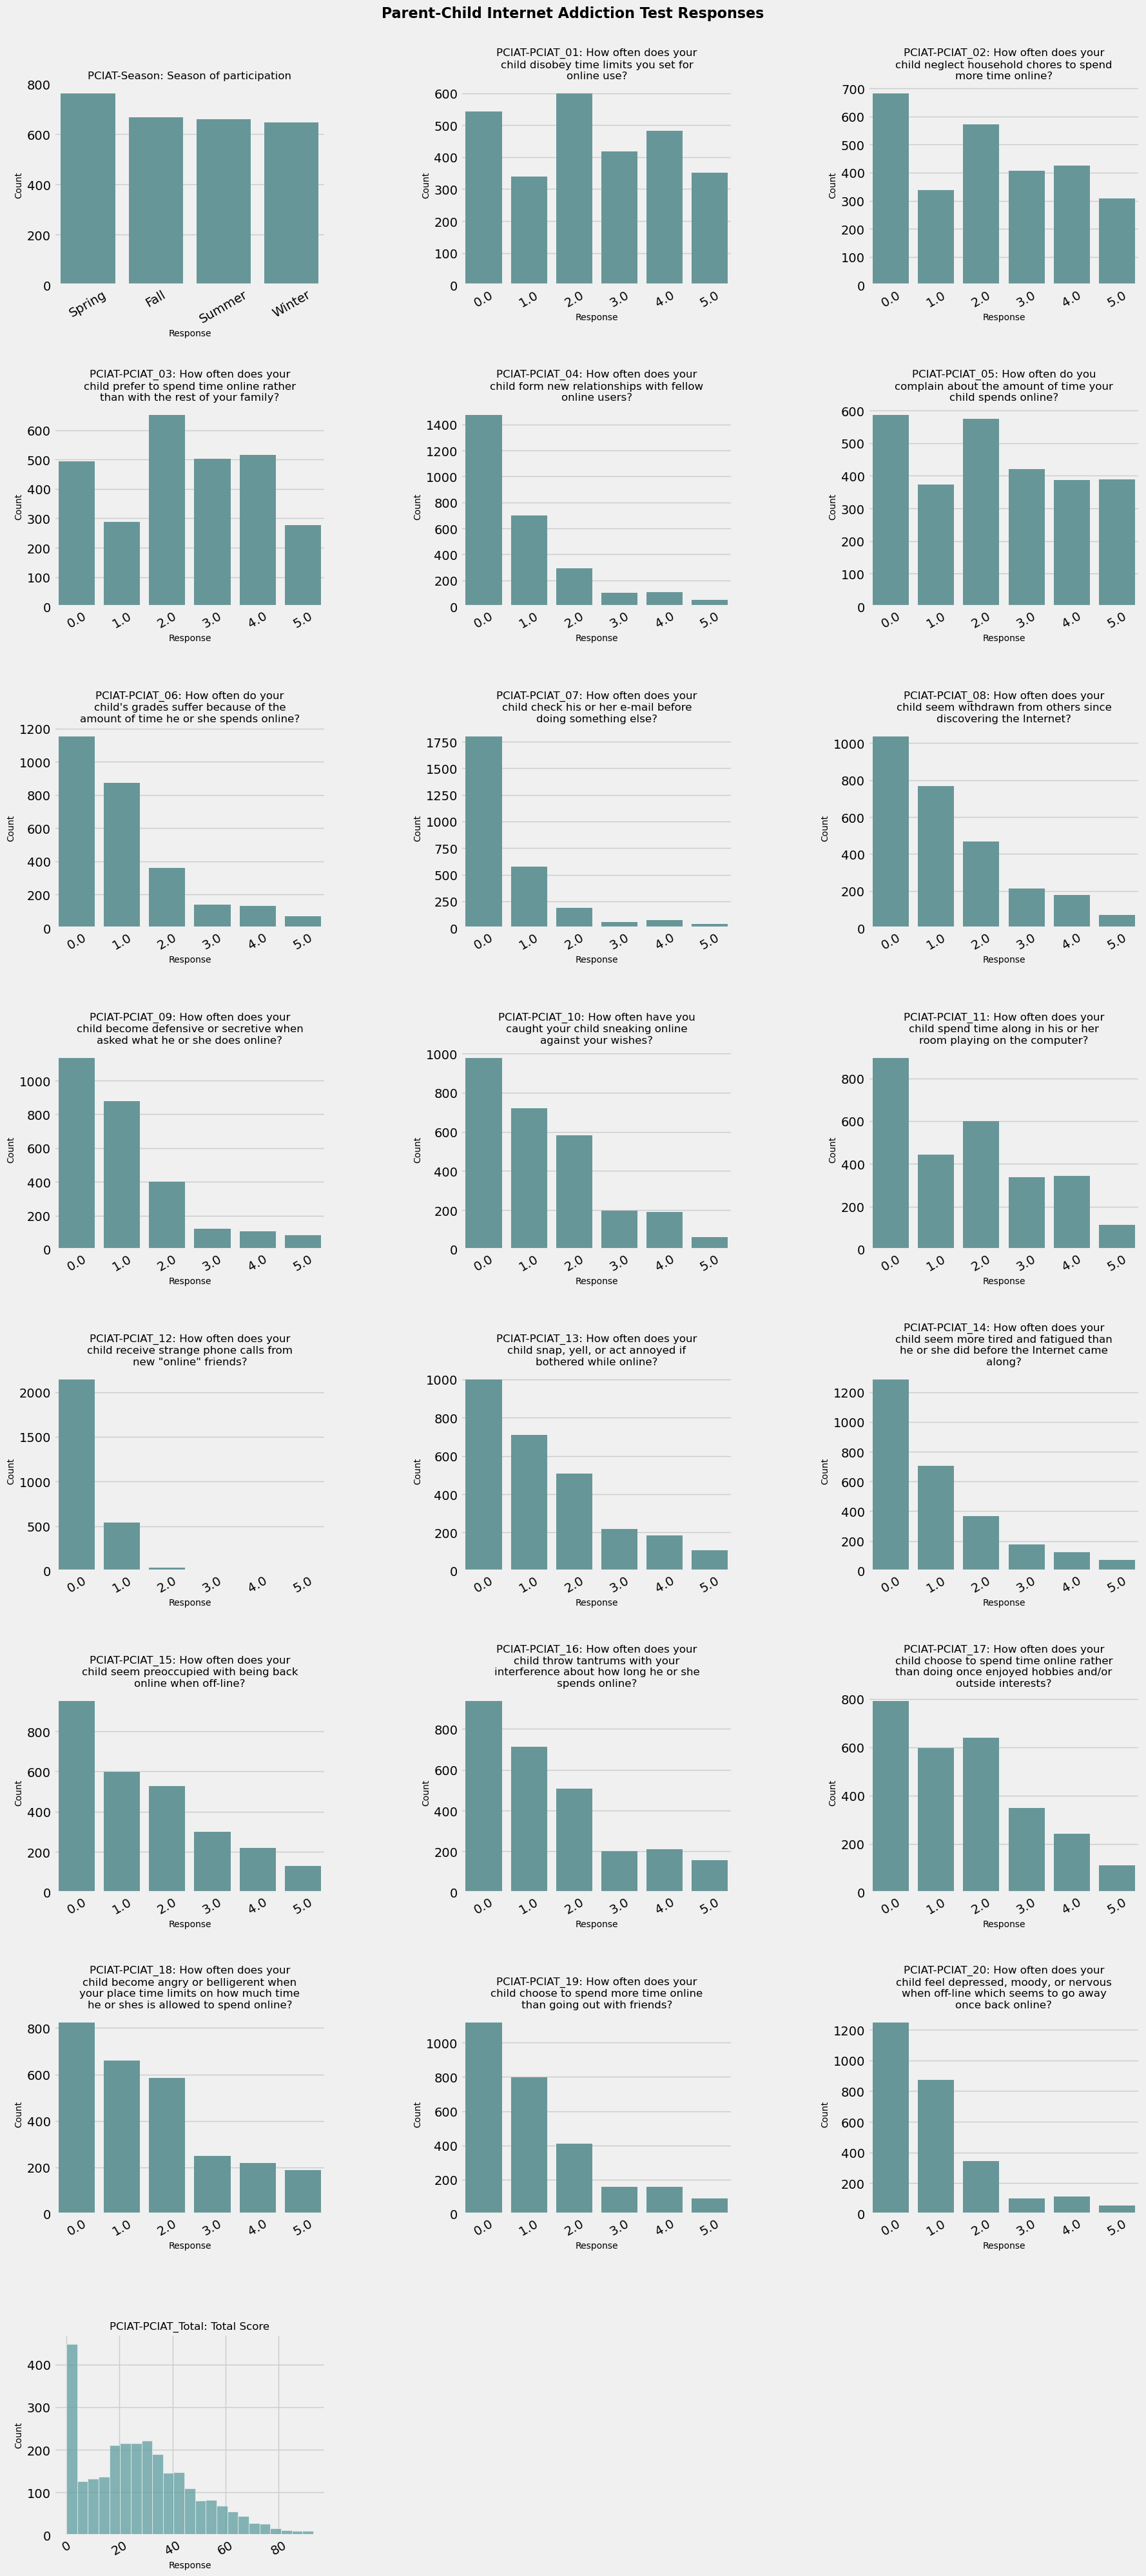

In [190]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'Parent-Child Internet Addiction Test Responses', num_cols=3)

<Axes: xlabel='sii', ylabel='PCIAT-PCIAT_Total'>

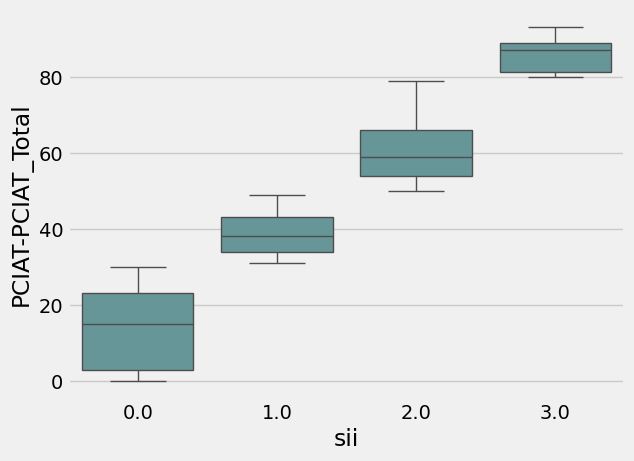

In [191]:
# sii was directly created from PCIAT Total
sns.boxplot(data=train_data, y='PCIAT-PCIAT_Total', x='sii', color='#5F9EA0')

In [192]:
print('These are the questions that most contribute to high PCIAT scores according to correlation:')
high_PCIAT_contributors = numeric_df.corr()['PCIAT-PCIAT_Total'].sort_values(ascending=False).head(30)
high_PCIAT_contributors = high_PCIAT_contributors[cols[1:-1]].sort_values(ascending=False)
display(high_PCIAT_contributors)

qs = high_PCIAT_contributors.index.values.tolist()
i = 0
print('\n\nThese are the PCIAT questions in order of importance to high scores:')
for q in qs:
    descr = data_dictionary.loc[data_dictionary['Field'] == q, 'Description'].values[0]
    print(f'{q}: {descr}')

These are the questions that most contribute to high PCIAT scores according to correlation:


PCIAT-PCIAT_05    0.830993
PCIAT-PCIAT_15    0.823996
PCIAT-PCIAT_17    0.823708
PCIAT-PCIAT_03    0.823336
PCIAT-PCIAT_18    0.802030
PCIAT-PCIAT_02    0.788802
PCIAT-PCIAT_13    0.771990
PCIAT-PCIAT_08    0.770499
PCIAT-PCIAT_16    0.769422
PCIAT-PCIAT_10    0.761463
PCIAT-PCIAT_20    0.754277
PCIAT-PCIAT_19    0.737243
PCIAT-PCIAT_01    0.727959
PCIAT-PCIAT_14    0.721995
PCIAT-PCIAT_09    0.720953
PCIAT-PCIAT_06    0.703261
PCIAT-PCIAT_11    0.684780
PCIAT-PCIAT_04    0.625394
PCIAT-PCIAT_07    0.491768
PCIAT-PCIAT_12    0.412194
Name: PCIAT-PCIAT_Total, dtype: float64



These are the PCIAT questions in order of importance to high scores:
PCIAT-PCIAT_05: How often do you complain about the amount of time your child spends online?
PCIAT-PCIAT_15: How often does your child seem preoccupied with being back online when off-line?
PCIAT-PCIAT_17: How often does your child choose to spend time online rather than doing once enjoyed hobbies and/or outside interests?
PCIAT-PCIAT_03: How often does your child prefer to spend time online rather than with the rest of your family?
PCIAT-PCIAT_18: How often does your child become angry or belligerent when your place time limits on how much time he or shes is allowed to spend online?
PCIAT-PCIAT_02: How often does your child neglect household chores to spend more time online?
PCIAT-PCIAT_13: How often does your child snap, yell, or act annoyed if bothered while online?
PCIAT-PCIAT_08: How often does your child seem withdrawn from others since discovering the Internet?
PCIAT-PCIAT_16: How often does your child throw 

## Sleep Disturbance Scale
Use SDS-SDS_Ttoa_T and drop SDS-SDS_Total_Raw

In [193]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Sleep Disturbance Scale', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'Sleep Disturbance Scale', 'Field']

print('\nThese are the value labels for each field of this instrument, if there are associated labels')
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Sleep Disturbance Scale', ['Field','Value Labels']])

print('\nThis is the missingness for each SDS question:')
train_data[cols].isna().mean()

,Field,Description
76,SDS-Season,Season of participation
77,SDS-SDS_Total_Raw,Total Raw Score
78,SDS-SDS_Total_T,Total T-Score



These are the value labels for each field of this instrument, if there are associated labels


,Field,Value Labels
76,SDS-Season,NaN
77,SDS-SDS_Total_Raw,NaN
78,SDS-SDS_Total_T,NaN



This is the missingness for each SDS question:


SDS-Season           0.338889
SDS-SDS_Total_Raw    0.341162
SDS-SDS_Total_T      0.341919
dtype: float64

- The Total Raw Score is the direct sum of the raw scores from each of the individual items on the SDSC. These items typically assess different sleep problems or disturbances, such as sleep onset difficulties, night awakenings, sleepwalking, or nightmares. Each item is rated on a scale (often a 5-point scale, e.g., 0 = never, 4 = always).
- The Total-T Score is a standardized score derived from the Total Raw Score. It adjusts for factors such as age, and the distribution of responses across a population, which allows for a comparison to a normative sample. The T-score is calculated in such a way that it has a mean of 50 and a standard deviation of 10 within the normative population.

**We should only keep one of these!**

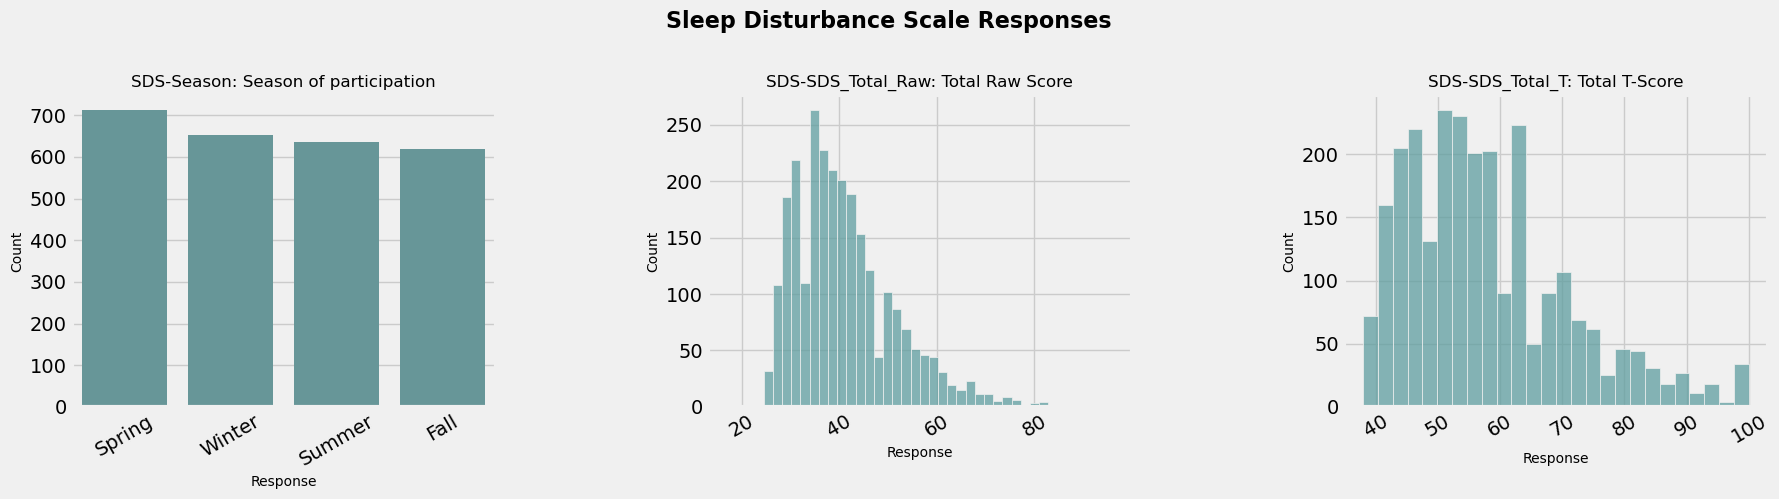

In [194]:
plot_columns(cols, data_dictionary, train_data, suptitle = 'Sleep Disturbance Scale Responses', num_cols=3)

## Internet Use

In [195]:
# These are the related columns and descriptions
display(data_dictionary.loc[data_dictionary['Instrument'] == 'Internet Use', ['Field', 'Description']])
cols = data_dictionary.loc[data_dictionary['Instrument'] == 'Internet Use', 'Field']

print('\nThis is the percent missingness for each PreInt question:')
train_data[cols].isna().mean()

,Field,Description
79,PreInt_EduHx-Season,Season of participation
80,PreInt_EduHx-computerinternet_hoursday,Hours of using computer/internet



This is the percent missingness for each PreInt question:


PreInt_EduHx-Season                       0.106061
PreInt_EduHx-computerinternet_hoursday    0.166414
dtype: float64

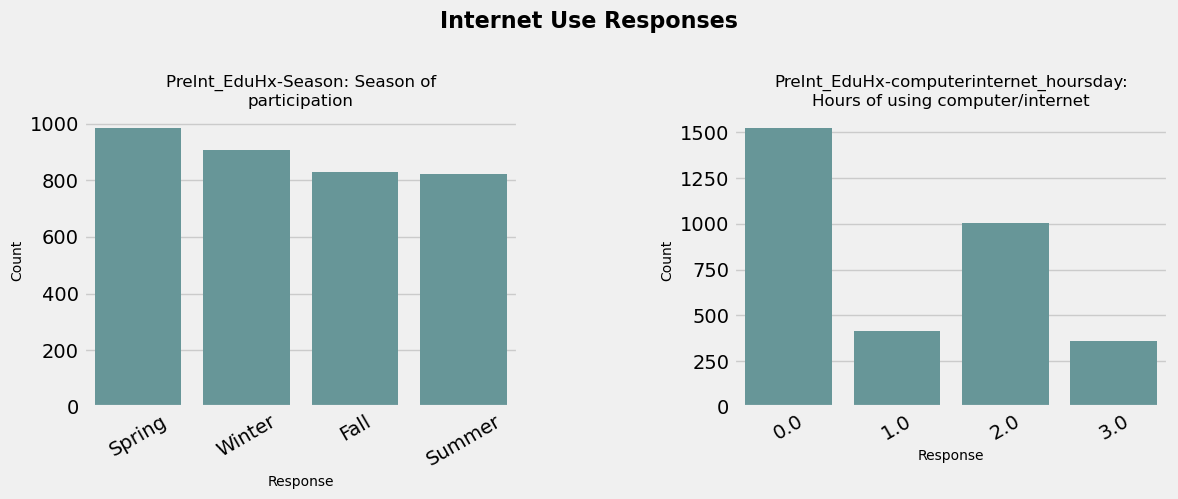

In [196]:
plot_columns(cols, data_dictionary, train_data, suptitle='Internet Use Responses', num_cols=2)

## Actigraphy Data

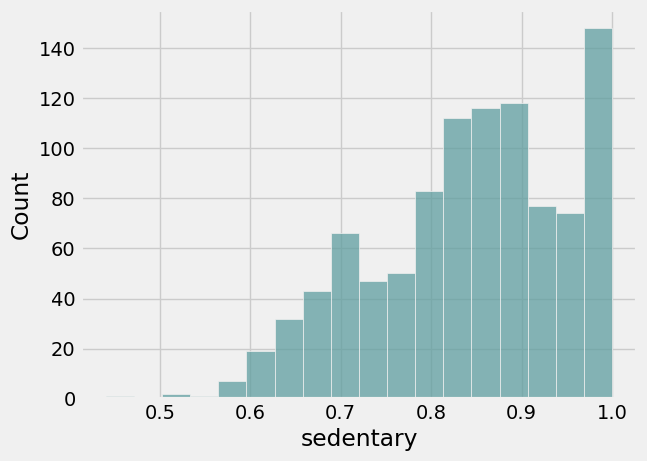

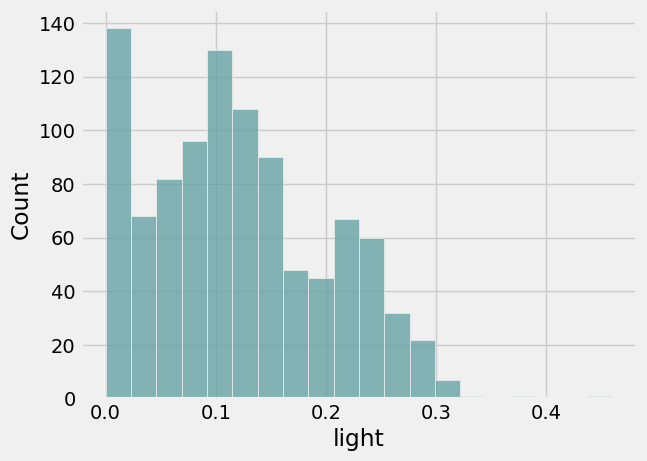

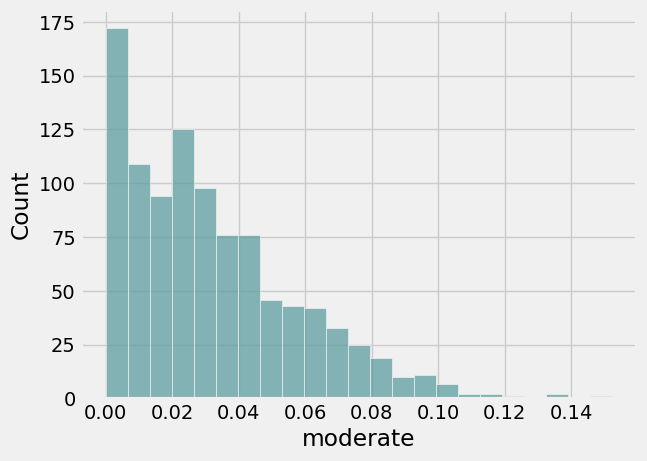

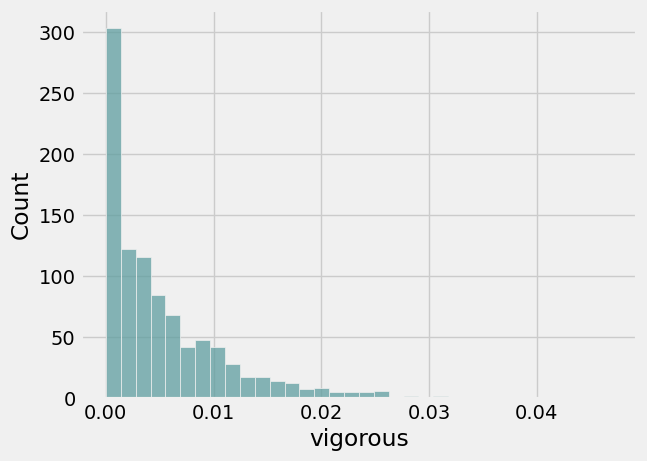

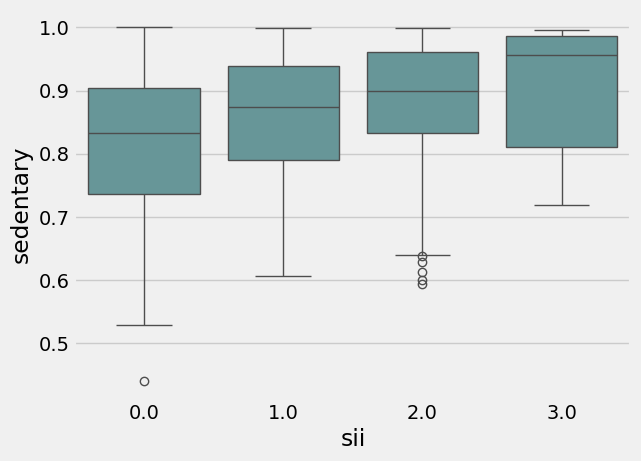

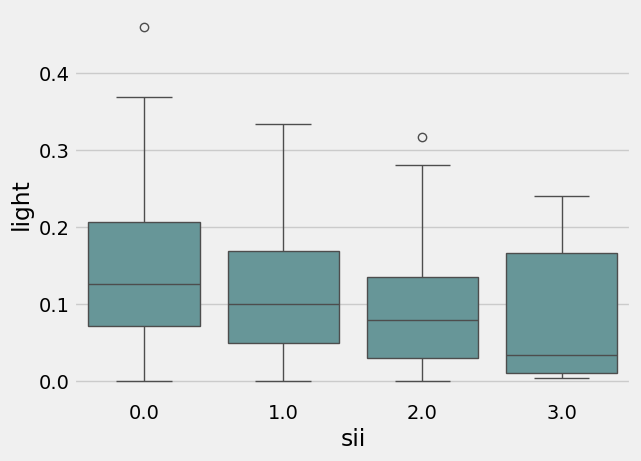

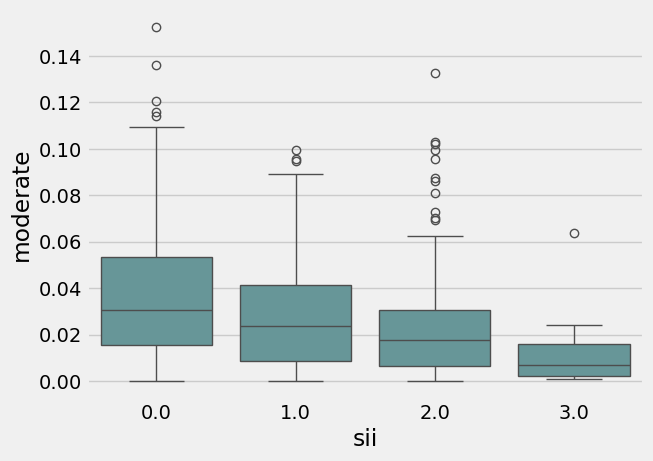

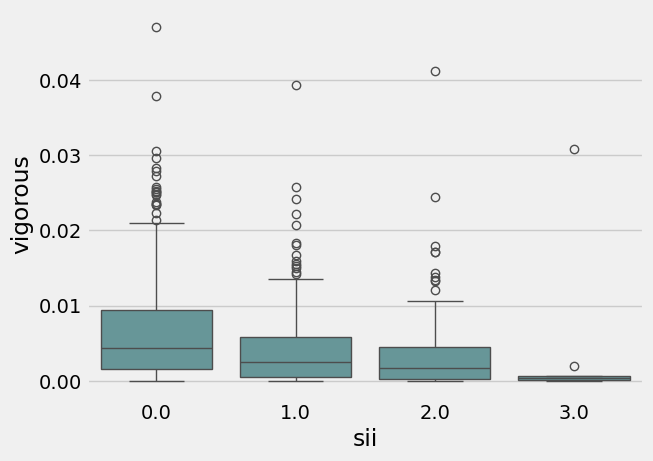

Correlation of actigraphy data with SII


sii          1.000000
sedentary    0.209381
light       -0.202668
moderate    -0.200408
vigorous    -0.187849
Name: sii, dtype: float64

In [197]:
actigraphy_data = pd.read_csv('data/PA_data.csv', index_col=0)
actigraphy_data = actigraphy_data.rename(columns = {'sendentary':'sedentary'})
sns.histplot(actigraphy_data['sedentary'], color=color)
plt.show()
sns.histplot(actigraphy_data['light'], color=color)
plt.show()
sns.histplot(actigraphy_data['moderate'], color=color)
plt.show()
sns.histplot(actigraphy_data['vigorous'], color=color)
plt.show()

# merge with train_data
train_data_merged = pd.merge(train_data, actigraphy_data, left_on='id', right_index=True)
# how is actigraphy data related to SII
sns.boxplot(x=train_data_merged['sii'], y=train_data_merged['sedentary'], color=color)
plt.show()
sns.boxplot(x=train_data_merged['sii'], y=train_data_merged['light'], color=color)
plt.show()
sns.boxplot(x=train_data_merged['sii'], y=train_data_merged['moderate'], color=color)
plt.show()
sns.boxplot(x=train_data_merged['sii'], y=train_data_merged['vigorous'], color=color)
plt.show()

# correlation of actigraphy data with SII
print('Correlation of actigraphy data with SII')
train_data_merged[['sii', 'sedentary', 'light', 'moderate', 'vigorous']].corr()['sii']

# how is actigraphy data related to other physical activity data?


# Data Cleaning
Our data can be broken down into physical activity, sleep, fitness, general functioning, internet usage, and health measures. When we are missing some physical activity/fitness/health measure data, do we have access to an alternative?

Here are the measures I would classify in each category:
- Physical Activity:
    - PAQ
    - Actigraphy
- Sleep:
    - SDS
    - Potentially actigraphy (if it's processed more)
- Fitness:
    - FitnessGram
    - Fitness_Endurance
- General Functioning:
    - CGAS
- Internet usage:
    - PreInt_EduHx-computerinternet_hoursday
- Health:
    - Physical
    - BIA

In [198]:
# combine FitnessGram Minutes and seconds
train_data['Fitness_Endurance-Total_Time_sec'] = train_data['Fitness_Endurance-Time_Mins'] * 60 + train_data['Fitness_Endurance-Time_Sec'] # remove remaining Fitness_Endurance Columns
# drop all PCIAT columns, any column that ends in -Season, FitnessGram Zones
columns_to_drop = [col for col in train_data.columns if col.startswith('PCIAT') or col.endswith('Season') or col.endswith('Zone')]
columns_to_drop.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins', 'SDS-SDS_Total_Raw'])
# Drop the identified columns
train_data_cleaned = train_data.drop(columns=columns_to_drop)

In [221]:
# include actigraphy data
train_data_cleaned = pd.merge(train_data_cleaned, actigraphy_data, left_on='id', how='outer', right_index=True)

In [222]:
# look at missing values on just the relevant columns now
train_data_cleaned.isna().mean().sort_values()

id                                        0.000000
Basic_Demos-Age                           0.000000
Basic_Demos-Sex                           0.000000
PreInt_EduHx-computerinternet_hoursday    0.166414
Physical-Weight                           0.223232
Physical-Height                           0.235606
Physical-BMI                              0.236869
Physical-HeartRate                        0.250758
Physical-Diastolic_BP                     0.254040
Physical-Systolic_BP                      0.254040
sii                                       0.309091
SDS-SDS_Total_T                           0.341919
CGAS-CGAS_Score                           0.388636
FGC-FGC_TL                                0.413131
FGC-FGC_CU                                0.413636
FGC-FGC_PU                                0.416667
FGC-FGC_SRR                               0.417424
FGC-FGC_SRL                               0.417929
BIA-BIA_Frame_num                         0.497222
BIA-BIA_Activity_Level_num     

We don't have actigraphy data for a lot of participants

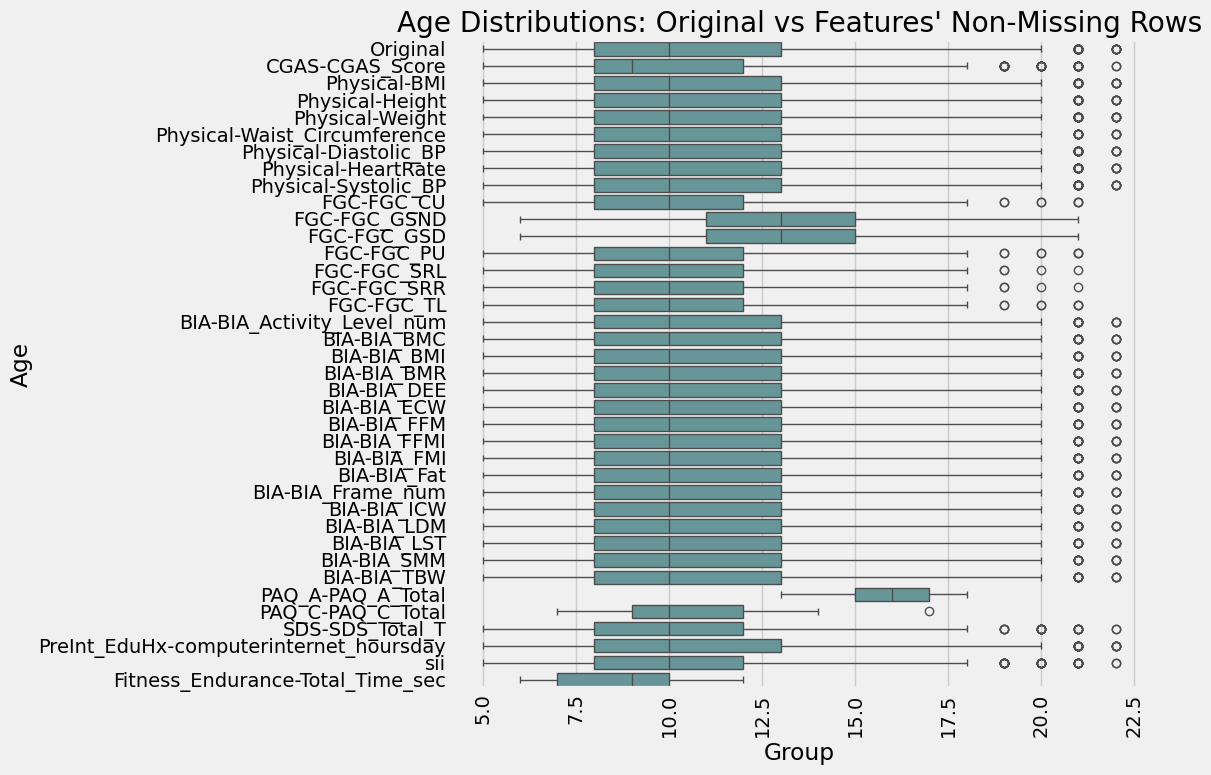

In [215]:
# Create a new DataFrame to store data for the boxplot
age_distributions = []

# Add the original age distribution
original_ages = train_data_cleaned['Basic_Demos-Age'].dropna()
age_distributions.extend([(age, "Original") for age in original_ages])

# Add age distributions for each feature's non-missing rows
for column in train_data_cleaned.columns[3:]:  # Skipping the age column
    filtered_data = train_data_cleaned[train_data_cleaned[column].notna()]
    ages = filtered_data['Basic_Demos-Age']
    age_distributions.extend([(age, column) for age in ages])

# Create a DataFrame for plotting
plot_df = pd.DataFrame(age_distributions, columns=['Age', 'Group'])

# Plot the boxplot
plt.figure(figsize=(8, 8))
sns.boxplot(y='Group', x='Age', data=plot_df, color=color)
plt.title("Age Distributions: Original vs Features' Non-Missing Rows")
plt.xlabel("Group")
plt.ylabel("Age")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

- For the most part, data was collected across all age ranges.
- The physical activity questionnaire for children and adolescents was clearly collected on different age groups, so we should see if those can be combined into one measure across age groups.
- Grip strength (FGC-FGC_GSND and FGC-FGC_GSD) seems to have been collected mostly for older children.
- Fitness_Endurane-Total_Time_sec seems to have been collected more for younger participants for some reason.


In [252]:
# merge separate child and adolescent instruments
print('The max and min are comparable for the Physical Activity Questionnaire across children and adolescents.')
print(train_data['PAQ_A-PAQ_A_Total'].min(), train_data['PAQ_A-PAQ_A_Total'].max())
print(train_data['PAQ_C-PAQ_C_Total'].min(), train_data['PAQ_C-PAQ_C_Total'].max())
# does anyone have both?
n_both = (train_data['PAQ_A-PAQ_A_Total'].notna() & train_data['PAQ_C-PAQ_C_Total'].notna()).sum()
print(f'{n_both} people/person have both the child and adolescent questionnaire.')
# keep adolescent value if 13 or older
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] >= 13), 'PAQ_C-PAQ_C_Total'] = np.nan
# keep child value is younger than 13
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] < 13), 'PAQ_C-PAQ_A_Total'] = np.nan
# merge columns
train_data_cleaned['PAQ-PAQ_Total'] = train_data_cleaned['PAQ_A-PAQ_A_Total'].fillna(train_data_cleaned['PAQ_C-PAQ_C_Total'])
# drop columns
train_data_cleaned = train_data_cleaned.drop(columns = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])

The max and min are comparable for the Physical Activity Questionnaire across children and adolescents.
0.66 4.71
0.58 4.79
1 people/person have both the child and adolescent questionnaire.


0.35909090909090907

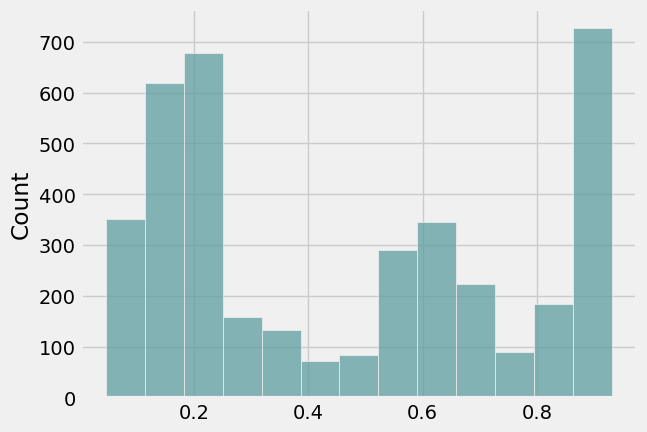

In [228]:
# row-wise missing values
row_missingness = train_data_cleaned.isna().mean(axis=1).sort_values()
sns.histplot(row_missingness, color = color)

(row_missingness > .6).mean()

In [38]:
# what are the characteristics of rows with high missingness?

# drop rows with more than 80% missing
percent_missing_per_row = train_data_cleaned.isnull().mean(axis=1) * 100
high_missingness_idx = percent_missing_per_row[percent_missing_per_row > 80].index.values
train_data_cleaned = train_data_cleaned.drop(high_missingness_idx)

# Bivariate Analysis
Can probably create a plotting function to make this quicker

In [ ]:
# correlation plot


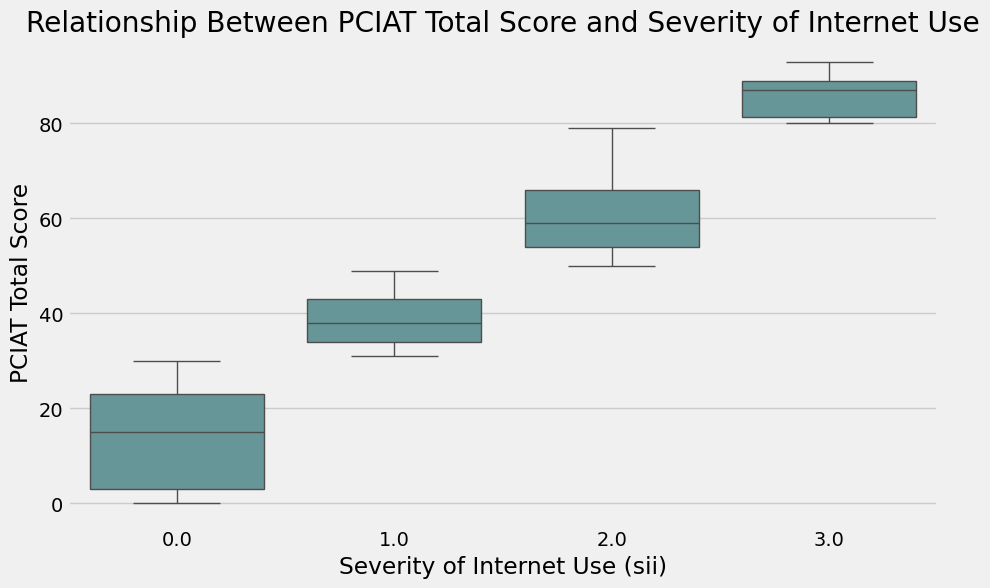

In [41]:
# PCIAT Total Score vs Target (sii)
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data, x='sii', y='PCIAT-PCIAT_Total', color=color)
plt.xlabel('Severity of Internet Use (sii)')
plt.ylabel('PCIAT Total Score')
plt.title('Relationship Between PCIAT Total Score and Severity of Internet Use')
plt.show()

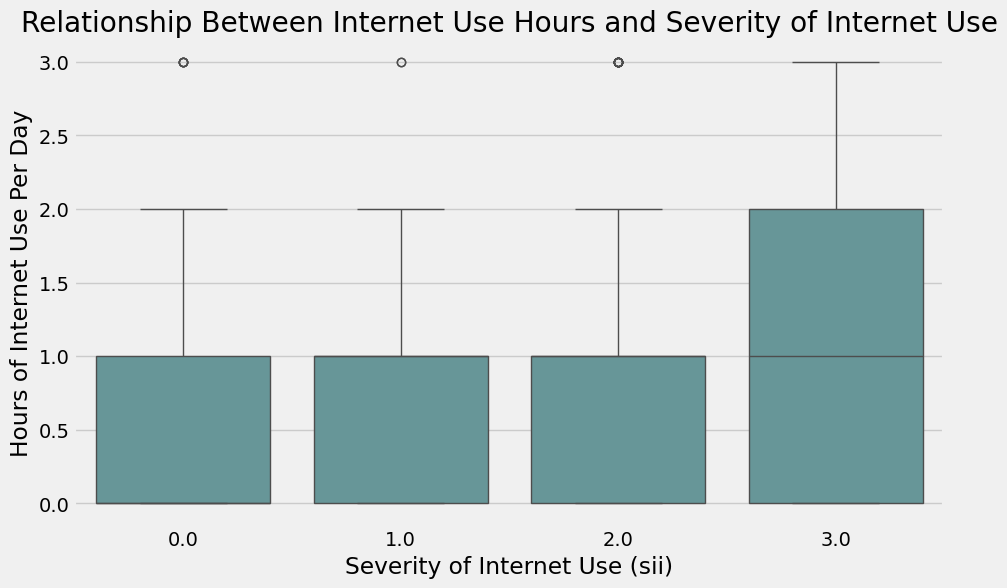

In [42]:
# Internet Use Hours vs Target (sii)
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data, x='PreInt_EduHx-computerinternet_hoursday', y='sii', color=color)
plt.xlabel('Severity of Internet Use (sii)')
plt.ylabel('Hours of Internet Use Per Day')
plt.title('Relationship Between Internet Use Hours and Severity of Internet Use')
plt.show()

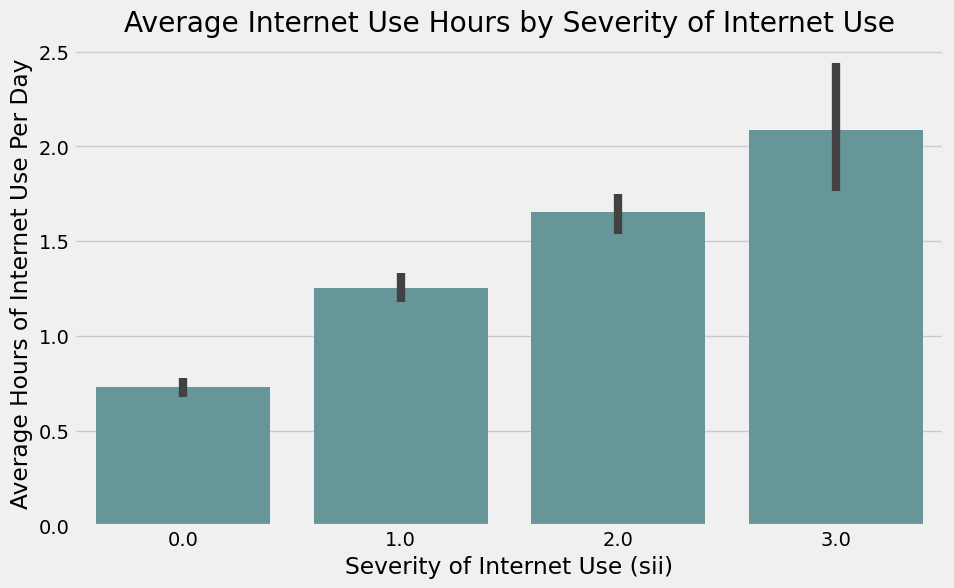

In [43]:
# Internet Use Hours vs Target (sii)
plt.figure(figsize=(10, 6))
sns.barplot(data=train_data, x='sii', y='PreInt_EduHx-computerinternet_hoursday', color=color)
plt.xlabel('Severity of Internet Use (sii)')
plt.ylabel('Average Hours of Internet Use Per Day')
plt.title('Average Internet Use Hours by Severity of Internet Use')
plt.show()

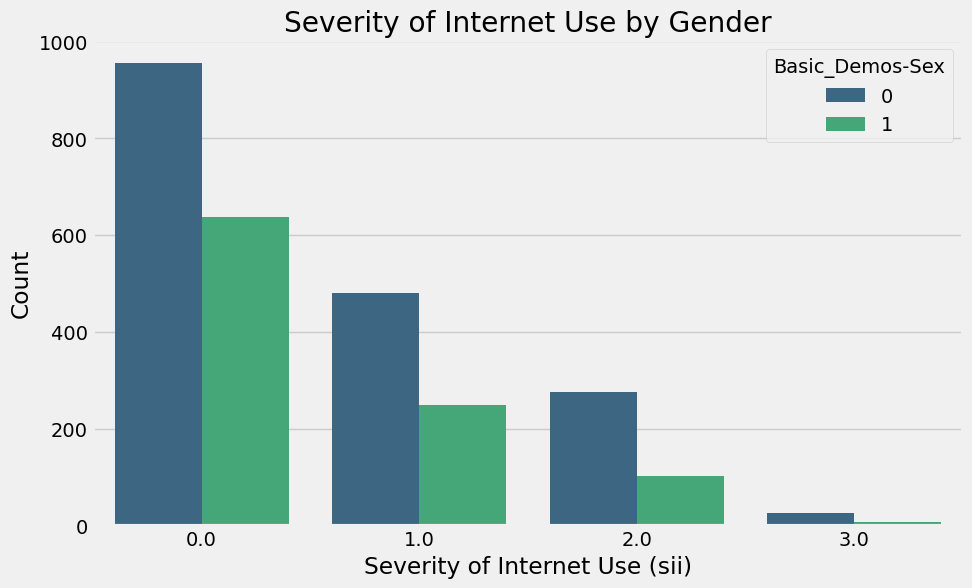

In [44]:
# Gender vs Target (sii)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='sii', hue='Basic_Demos-Sex', palette='viridis')
plt.xlabel('Severity of Internet Use (sii)')
plt.ylabel('Count')
plt.title('Severity of Internet Use by Gender')
plt.show()

In [ ]:
# Compare measures that might be related

# Compare physical measures and BIA

# compare fitnessGram and PAQ
